# Informations

## One script = one condition to make it easier to follow and correct.

### I am working in local for this analysis

### This script starts by taking the variant counts csv files and concatenate them together in a long df with all the reads and other informations. 

### After, with the long dataframe containing all reads for all variants it does some quality control. Then it calculates the selection coefficient. The last steps are the heatmaps and variants categorization.

#### The goal of the script is to be a linear analysis where it's easy to find information back, so it's not made to make tests. If something is wrong at any quality control step, go in another notebook to find the problem. I open other notebooks for most quality control and if there are a lot of figures to make or other things to verify.

### 1- Wide to long dataframe
### 2- Lanes control
### 3- Selection coefficient
### 4- Replicates control
### 5- Codons control
### 6- Overlaps control
### 7- Heatmaps and figures
### 8- t-test significant resistance

#### I save the dataframes along the way to be able to use them elsewhere. Dataframes and figures are saved automatically with the information given at the beginning (date+experiment).

In [1]:
#### Import packages needed (and some not needed....)

import Bio

import openpyxl
from Bio import SeqIO
import os,sys,re

import pandas as pd
print(pd.__name__, pd.__version__)

import numpy as np
print(np.__name__, np.__version__)

import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__name__, matplotlib.__version__)
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

import scipy.stats as stats
import scipy
print(scipy.__name__, scipy.__version__)

import seaborn as sns
print(sns.__name__, sns.__version__)

from collections import Counter

import scipy as sp
import math
from scipy.stats import shapiro 
from scipy.stats import lognorm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_rel

pandas 1.5.2
numpy 1.23.5
matplotlib 3.4.1
scipy 1.10.0
seaborn 0.12.2


In [2]:
# Set up
# Here we can find all informations needed to run the script without changing code along the way. It limits errors.

##Condition

condition = "No antifungal" #complete name
cond = "None" #abbreviation useed in the dataframes

##date + experiment

date = "2023-12-07" #date of this analysis
date_info = "2023-03-14" #date on the reads information files
year = "2023" #year on the reads count files

experiment = "NovaSeq_winter2023_albicans"

## lists

cancel_list = [92,228, 232,233,234] #positions that did not work for ant reasons

stop_list = [55,89,119,139,197,238,307,370,408,466,506] #list of stop codons in the library

#positions lists

f1_f2_over = [154,155,158,162]
f2_f3_over = [276,277,280] #275 was supposed to be there, but it's cut because of the primer
f3_f4_over = [401,402,403,404,405,406] #407 was supposed to be there, but it's cut because of the primer

over_list = [154,155,158,162,276,277,280,401,402,403,404,405,406] #all overlap

#codons

Ca_ERG11 = "ATGGCCATTGTTGAAACGGTAATAGATGGAATCAACTATTTTTTATCACTGTCTGTAACTCAACAAATTAGTATATTACTAGGGGTCCCGTTTGTGTACAATCTGGTTTGGCAGTATTTATATAGTCTAAGAAAAGATAGAGCACCCCTGGTATTCTATTGGATACCCTGGTTCGGCTCAGCAGCGTCTTATGGTCAACAACCGTATGAATTTTTTGAGTCATGCAGGCAGAAATATGGCGATGTTTTTTCCTTTATGCTTCTTGGGAAAATAATGACTGTGTACCTTGGCCCAAAGGGTCACGAATTTGTCTTCAATGCGAAGTTAAGCGATGTCTCTGCTGAAGATGCATACAAACACTTAACAACTCCGGTATTCGGAAAGGGAGTTATCTACGATTGTCCCAACAGTCGTCTGATGGAGCAGAAAAAGTTTGCTAAATTCGCGCTTACTACGGACTCATTCAAAAGGTATGTACCCAAAATTCGTGAAGAAATATTAAACTATTTCGTAACAGACGAAAGTTTCAAATTAAAGGAAAAGACACACGGCGTGGCTAACGTGATGAAAACACAACCTGAAATCACCATTTTTACCGCCAGCAGGTCCTTATTTGGCGACGAGATGAGAAGAATTTTCGATAGAAGTTTTGCTCAACTGTACTCAGATTTGGATAAAGGTTTTACTCCGATAAATTTCGTGTTCCCAAACCTTCCTTTGCCACACTATTGGAGAAGAGATGCTGCACAAAAGAAGATAAGTGCGACCTATATGAAAGAGATAAAATCCCGTAGGGAAAGGGGTGACATTGACCCTAACAGAGACTTGATTGATTCTCTGCTGATTCATAGCACATACAAAGACGGTGTGAAGATGACCGACCAGGAGATTGCAAACCTGCTTATAGGTATTTTAATGGGTGGACAGCACACATCAGCTTCTACGTCAGCATGGTTTCTGCTACACCTGGGGGAAAAACCGCACCTACAAGACGTAATATATCAAGAGGTGGTGGAGTTACTAAAAGAGAAAGGAGGCGATCTAAACGATTTAACCTATGAGGATCTGCAAAAATTGCCGTCAGTCAACAACACGATCAAGGAAACGCTAAGGATGCACATGCCTCTACACAGTATATTCAGAAAAGTTACTAACCCACTTAGGATCCCTGAAACCAACTACATCGTCCCAAAAGGACACTACGTTCTTGTCAGCCCAGGCTACGCACACACGAGTGAGAGATACTTTGATAACCCGGAGGATTTTGATCCTACACGTTGGGATACTGCTGCAGCCAAAGCCAATTCTGTAAGCTTTAACTCCAGTGATGAGGTAGATTACGGCTTTGGGAAAGTATCAAAAGGCGTCAGCTCACCATATCTTCCCTTCGGTGGCGGTAGACATAGATGTATAGGTGAACAATTTGCATACGTTCAGCTGGGAACCATATTAACGACGTTTGTTTATAACTTGAGATGGACTATCGACGGGTATAAAGTCCCTGATCCTGACTATAGCTCTATGGTTGTTctaCCCACCGAACCGGCTGAAATAATTTGGGAGAAAAGAGAGACATGTATGTTTTGA"

DNA_Codons = {"GCT": "A", "GCC": "A", "GCA": "A", "GCG": "A","TGT": "C", "TGC": "C",
    "GAT": "D", "GAC": "D","GAA": "E", "GAG": "E","TTT": "F", "TTC": "F",
    "GGT": "G", "GGC": "G", "GGA": "G", "GGG": "G","CAT": "H", "CAC": "H","ATA": "I", "ATT": "I", "ATC": "I",
    "AAA": "K", "AAG": "K", "TTA": "L", "TTG": "L", "CTT": "L", "CTC": "L", "CTA": "L", "CTG": "L",
    "ATG": "M","AAT": "N", "AAC": "N","CCT": "P", "CCC": "P", "CCA": "P", "CCG": "P","CAA": "Q", "CAG": "Q",
    "CGT": "R", "CGC": "R", "CGA": "R", "CGG": "R", "AGA": "R", "AGG": "R","TCT": "S", "TCC": "S", "TCA": "S", 
    "TCG": "S", "AGT": "S", "AGC": "S","ACT": "T", "ACC": "T", "ACA": "T", "ACG": "T",
    "GTT": "V", "GTC": "V", "GTA": "V", "GTG": "V","TGG": "W","TAT": "Y", "TAC": "Y","TAA": "*", "TAG": "*", "TGA": "*"}

In [3]:
#open df with wt positions

WT_annot = pd.read_excel('../wt_aa_annot.xlsx', header=0)

aa_wt1 = pd.melt(WT_annot, id_vars=['aa'])

#keep only WT rows

aa_wt1 = aa_wt1[aa_wt1['value'] == 'o'].reset_index(drop=True)

#make a dictionnary of position + wt aa

aa_dict = dict(zip(aa_wt1['variable'], aa_wt1['aa']))

# 1- Wide to long dataframe

In [79]:
##taked all variant counts csv files to have a long df

##sorry this is the most horrible function I ever made (but somehow it works)

def wide_to_long(path_vari, path_info):
    
    df_info = pd.read_excel(path_info, header=0)
    df_info = df_info.sort_values(by='Name', ignore_index=True)
    
    files = [os.path.join(path_vari, i) for i in os.listdir(path_vari) if os.path.isfile(os.path.join(path_vari, i))]
    
    name_list = []
    
    # Get a list of the files names
    for name in files:
        file_name = os.path.splitext(os.path.basename(name))[0]
        name_list.append(file_name)
    
    dict_df = {}
    
    # For every file in the folder, read it and append to an empty dict
    for i in range(len(files)):
        print(str(files[i]))
        df = pd.read_csv(files[i], index_col=0)
        dict_df[name_list[i]] = df
        
    dict_melt = {}
    
    # Variants df wide to long
    for key in dict_df:
        df_reads = dict_df[key]
        dfm = df_reads.melt(ignore_index=False).reset_index()
        dfm = dfm.rename(columns={"index": "codon", "variable": "position", "value": "nbr_reads"})
        dict_melt[key] = dfm
        
    dict_df_long = {}
    inter = 0
    
    # Add the info in the long df
    for key in dict_melt:
        info = df_info

        times = len(dict_melt[key])
        con = info.iloc[inter, 3]
        tp = info.iloc[inter, 5]
        ant = info.iloc[inter, 6]
        frag = info.iloc[inter, 7]
        rep = info.iloc[inter, 8]
        la = info.iloc[inter, 9]
        OD = info.iloc[inter, 10]
        want = info.iloc[inter, 11]
        beef = info.iloc[inter, 12]
        afme = info.iloc[inter, 14]
        single = info.iloc[inter, 19]
        align = info.iloc[inter, 21]
        wt = info.iloc[inter, 22]

        chunk = pd.DataFrame({'Condition': [con], 'Timepoint': [tp], "Antifungal": [ant], "Fragment": [frag],
                              "Replicate": [rep], "Lane": [la], "OD": [OD], "reads_wanted": [want], "reads_before": [beef],
                              "reads_after_merge": [afme], "nbr_reads_single": [single], "reads_align": [align],
                              "reads_wt": [wt]})

        lala = chunk.loc[chunk.index.repeat(times)]
        lolilol = lala.reset_index()

        yay = pd.concat([dict_melt[key], lolilol], axis=1)
        print(yay)
        dict_df_long[key] = yay

        inter += 1
        
    df_list = list(dict_df_long.values())
    df_big = {}

    # Concatenate everybody together
    for i in range(len(df_list)):

        if i == 0:

            s1 = df_list[i]
            s2 = df_list[i + 1]
            df_big = pd.concat([s1, s2])
        
        elif i < len(df_list) and i != 0 and not i >= len(df_list) - 1:

            s1 = df_list[i + 1]
            df_big = pd.concat([df_big, s1], axis=0, ignore_index=True)
        
        else:
            print("The end")
        
    return df_big

In [ ]:
F4_long = wide_to_long('../Variants Count/Fragment 4/',f"../Reads_info/Reads_count_CaERG11-F4_all.xlsx")
F3_long = wide_to_long('../Variants Count/Fragment 3/',f"../Reads_info/Reads_count_CaERG11-F3_all.xlsx")
F2_long = wide_to_long('../Variants Count/Fragment 2/',f"../Reads_info/Reads_count_CaERG11-F2_all.xlsx")
F1_long = wide_to_long('../Variants Count/Fragment 1/',f"../Reads_info/Reads_count_CaERG11-F1_all.xlsx")

F1_2_long = pd.concat([F1_long,F2_long],axis=0)
F3_4_long = pd.concat([F3_long, F4_long],axis=0)
All_long = pd.concat([F1_2_long, F3_4_long],axis=0)

All_long.to_csv(f'Long_df_variants_reads_final_{date}.csv')  

All_long

../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Clotri_F4_A_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Clotri_F4_B_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Clotri_F4_C_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Fluco_F4_1_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Fluco_F4_2_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Fluco_F4_3_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Isa_F4_A_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Isa_F4_B_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Isa_F4_C_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Itra_F4_A_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Itra_F4_B_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Itra_F4_C_2023-06-20.cs

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT      401       21.0      0  CaERG11_2_Clotri_F4_A          2   
1      GCC      401        8.0      0  CaERG11_2_Clotri_F4_A          2   
2      TGC      401       66.0      0  CaERG11_2_Clotri_F4_A          2   
3      TGT      401       36.0      0  CaERG11_2_Clotri_F4_A          2   
4      GAT      401        8.0      0  CaERG11_2_Clotri_F4_A          2   
...    ...      ...        ...    ...                    ...        ...   
2062   GTC      511      303.0      0  CaERG11_2_Clotri_F4_A          2   
2063   TGG      511      423.0      0  CaERG11_2_Clotri_F4_A          2   
2064   TAC      511       25.0      0  CaERG11_2_Clotri_F4_A          2   
2065   TAT      511       27.0      0  CaERG11_2_Clotri_F4_A          2   
2066   TAA      511        NaN      0  CaERG11_2_Clotri_F4_A          2   

     Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0        Clotri       F4       

     codon position  nbr_reads  index            Condition  Timepoint  \
0      GCT      401      534.0      0  CaERG11_3_None_F4_1          3   
1      GCC      401      282.0      0  CaERG11_3_None_F4_1          3   
2      TGC      401      343.0      0  CaERG11_3_None_F4_1          3   
3      TGT      401      460.0      0  CaERG11_3_None_F4_1          3   
4      GAT      401      217.0      0  CaERG11_3_None_F4_1          3   
...    ...      ...        ...    ...                  ...        ...   
2062   GTC      511      283.0      0  CaERG11_3_None_F4_1          3   
2063   TGG      511      305.0      0  CaERG11_3_None_F4_1          3   
2064   TAC      511      320.0      0  CaERG11_3_None_F4_1          3   
2065   TAT      511      209.0      0  CaERG11_3_None_F4_1          3   
2066   TAA      511        NaN      0  CaERG11_3_None_F4_1          3   

     Antifungal Fragment  Replicate  Lane        OD  reads_wanted  \
0          None       F4          1  L001  8.667466   

The end
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Clotri_F3_A_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Clotri_F3_B_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Clotri_F3_C_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_1_L001_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_1_L002_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_2_L001_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_2_L002_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_3_L001_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_3_L002_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Isa_F3_A_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Isa_F3_B_2023-06-20.csv
../Variants Count/Fragment 3/Variants_c

     codon position  nbr_reads  index            Condition  Timepoint  \
0      GCT      276      176.0      0  CaERG11_0_None_F3_2          0   
1      GCC      276      270.0      0  CaERG11_0_None_F3_2          0   
2      TGC      276      323.0      0  CaERG11_0_None_F3_2          0   
3      TGT      276      154.0      0  CaERG11_0_None_F3_2          0   
4      GAT      276      199.0      0  CaERG11_0_None_F3_2          0   
...    ...      ...        ...    ...                  ...        ...   
2101   GTC      406      289.0      0  CaERG11_0_None_F3_2          0   
2102   TGG      406      192.0      0  CaERG11_0_None_F3_2          0   
2103   TAC      406      464.0      0  CaERG11_0_None_F3_2          0   
2104   TAT      406      229.0      0  CaERG11_0_None_F3_2          0   
2105   TAA      406        NaN      0  CaERG11_0_None_F3_2          0   

     Antifungal Fragment  Replicate  Lane    OD  reads_wanted  reads_before  \
0          None       F3          2  L001  7

     codon position  nbr_reads  index             Condition  Timepoint  \
0      GCT      276       26.0      0  CaERG11_2_Fluco_F3_3          2   
1      GCC      276       17.0      0  CaERG11_2_Fluco_F3_3          2   
2      TGC      276       38.0      0  CaERG11_2_Fluco_F3_3          2   
3      TGT      276       24.0      0  CaERG11_2_Fluco_F3_3          2   
4      GAT      276      495.0      0  CaERG11_2_Fluco_F3_3          2   
...    ...      ...        ...    ...                   ...        ...   
2101   GTC      406      357.0      0  CaERG11_2_Fluco_F3_3          2   
2102   TGG      406      144.0      0  CaERG11_2_Fluco_F3_3          2   
2103   TAC      406     1133.0      0  CaERG11_2_Fluco_F3_3          2   
2104   TAT      406      732.0      0  CaERG11_2_Fluco_F3_3          2   
2105   TAA      406        1.0      0  CaERG11_2_Fluco_F3_3          2   

     Antifungal Fragment  Replicate  Lane        OD  reads_wanted  \
0         Fluco       F3          3  L002 

     codon position  nbr_reads  index            Condition  Timepoint  \
0      GCT      276      321.0      0  CaERG11_3_None_F3_1          3   
1      GCC      276      379.0      0  CaERG11_3_None_F3_1          3   
2      TGC      276      443.0      0  CaERG11_3_None_F3_1          3   
3      TGT      276      212.0      0  CaERG11_3_None_F3_1          3   
4      GAT      276      295.0      0  CaERG11_3_None_F3_1          3   
...    ...      ...        ...    ...                  ...        ...   
2101   GTC      406      388.0      0  CaERG11_3_None_F3_1          3   
2102   TGG      406       57.0      0  CaERG11_3_None_F3_1          3   
2103   TAC      406      284.0      0  CaERG11_3_None_F3_1          3   
2104   TAT      406      141.0      0  CaERG11_3_None_F3_1          3   
2105   TAA      406        NaN      0  CaERG11_3_None_F3_1          3   

     Antifungal Fragment  Replicate  Lane        OD  reads_wanted  \
0          None       F3          1  L001  8.104337   

The end
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Clotri_F2_A_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Clotri_F2_B_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Clotri_F2_C_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_1_L001_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_1_L002_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_2_L001_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_2_L002_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_3_L001_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_3_L002_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Isa_F2_A_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Isa_F2_B_2023-06-20.csv
../Variants Count/Fragment 2/Variants_c

# 2- Control between lanes

In [6]:
#import the long df with all variants reads

df = pd.read_csv(f'Long_df_variants_reads_final_{date}.csv', header=0, index_col = 0)
df = df.drop("index",axis=1)
df = df.reset_index()
df = df.drop("index",axis=1)
df

codon  position  nbr_reads              Condition  Timepoint  \
0        GCT        55      528.0  CaERG11_0_Clotri_F1_A          0   
1        GCC        55      386.0  CaERG11_0_Clotri_F1_A          0   
2        TGC        55      532.0  CaERG11_0_Clotri_F1_A          0   
3        TGT        55      601.0  CaERG11_0_Clotri_F1_A          0   
4        GAT        55      628.0  CaERG11_0_Clotri_F1_A          0   
...      ...       ...        ...                    ...        ...   
448807   GTC       511      235.0    CaERG11_3_None_F4_3          3   
448808   TGG       511      293.0    CaERG11_3_None_F4_3          3   
448809   TAC       511      360.0    CaERG11_3_None_F4_3          3   
448810   TAT       511      198.0    CaERG11_3_None_F4_3          3   
448811   TAA       511        1.0    CaERG11_3_None_F4_3          3   

       Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0          Clotri       F1         A  L001  0.000000       5000000   
1          Clotri       F1         A  L001  0.000000       5000000   
2          Clotri       F1         A  L001  0.000000       5000000   
3          Clotri       F1         A  L001  0.000000       5000000   
4          Clotri       F1         A  L001  0.000000       5000000   
...           ...      ...       ...   ...       ...           ...   
448807       None       F4         3  L002  8.291309       2500000   
448808       None       F4         3  L002  8.291309       2500000   
448809       None       F4         3  L002  8.291309       2500000   
448810       None       F4         3  L002  8.291309       2500000   
448811       None       F4         3  L002  8.291309       2500000   

        reads_before  reads_after_merge  nbr_reads_single  reads_align  \
0            5286093            4989961           1113525      4954935   
1            5286093            4989961           1113525      4954935   
2            5286093            4989961           1113525      4954935   
3            5286093            4989961           1113525      4954935   
4            5286093            4989961           1113525      4954935   
...              ...                ...               ...          ...   
448807       1657998            1625552            449165      1596281   
448808       1657998            1625552            449165      1596281   
448809       1657998            1625552            449165      1596281   
448810       1657998            1625552            449165      1596281   
448811       1657998            1625552            449165      1596281   

        reads_wt  
0         444237  
1         444237  
2         444237  
3         444237  
4         444237  
...          ...  
448807    216412  
448808    216412  
448809    216412  
448810    216412  
448811    216412  

[448812 rows x 16 columns]

In [7]:
#remove all positions that did not worked for any reason and that are stops not in the library
#takes like 1 minute

to_drop = []

for index, row in df.iterrows():
    if row["position"] in cancel_list:
        to_drop.append(index)
    elif row['position'] not in stop_list and row["codon"] == "TAA":
        to_drop.append(index)

df = df.drop(to_drop)
df

codon  position  nbr_reads              Condition  Timepoint  \
0        GCT        55      528.0  CaERG11_0_Clotri_F1_A          0   
1        GCC        55      386.0  CaERG11_0_Clotri_F1_A          0   
2        TGC        55      532.0  CaERG11_0_Clotri_F1_A          0   
3        TGT        55      601.0  CaERG11_0_Clotri_F1_A          0   
4        GAT        55      628.0  CaERG11_0_Clotri_F1_A          0   
...      ...       ...        ...                    ...        ...   
448806   GTT       511      197.0    CaERG11_3_None_F4_3          3   
448807   GTC       511      235.0    CaERG11_3_None_F4_3          3   
448808   TGG       511      293.0    CaERG11_3_None_F4_3          3   
448809   TAC       511      360.0    CaERG11_3_None_F4_3          3   
448810   TAT       511      198.0    CaERG11_3_None_F4_3          3   

       Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0          Clotri       F1         A  L001  0.000000       5000000   
1          Clotri       F1         A  L001  0.000000       5000000   
2          Clotri       F1         A  L001  0.000000       5000000   
3          Clotri       F1         A  L001  0.000000       5000000   
4          Clotri       F1         A  L001  0.000000       5000000   
...           ...      ...       ...   ...       ...           ...   
448806       None       F4         3  L002  8.291309       2500000   
448807       None       F4         3  L002  8.291309       2500000   
448808       None       F4         3  L002  8.291309       2500000   
448809       None       F4         3  L002  8.291309       2500000   
448810       None       F4         3  L002  8.291309       2500000   

        reads_before  reads_after_merge  nbr_reads_single  reads_align  \
0            5286093            4989961           1113525      4954935   
1            5286093            4989961           1113525      4954935   
2            5286093            4989961           1113525      4954935   
3            5286093            4989961           1113525      4954935   
4            5286093            4989961           1113525      4954935   
...              ...                ...               ...          ...   
448806       1657998            1625552            449165      1596281   
448807       1657998            1625552            449165      1596281   
448808       1657998            1625552            449165      1596281   
448809       1657998            1625552            449165      1596281   
448810       1657998            1625552            449165      1596281   

        reads_wt  
0         444237  
1         444237  
2         444237  
3         444237  
4         444237  
...          ...  
448806    216412  
448807    216412  
448808    216412  
448809    216412  
448810    216412  

[427620 rows x 16 columns]

In [8]:
#keep only rows with the condition your analysing

df_anti = df.groupby("Antifungal")
df = df_anti.get_group(cond)
df

codon  position  nbr_reads            Condition  Timepoint Antifungal  \
45045    GCT        55      581.0  CaERG11_0_None_F1_1          0       None   
45046    GCC        55      413.0  CaERG11_0_None_F1_1          0       None   
45047    TGC        55      540.0  CaERG11_0_None_F1_1          0       None   
45048    TGT        55      649.0  CaERG11_0_None_F1_1          0       None   
45049    GAT        55      692.0  CaERG11_0_None_F1_1          0       None   
...      ...       ...        ...                  ...        ...        ...   
448806   GTT       511      197.0  CaERG11_3_None_F4_3          3       None   
448807   GTC       511      235.0  CaERG11_3_None_F4_3          3       None   
448808   TGG       511      293.0  CaERG11_3_None_F4_3          3       None   
448809   TAC       511      360.0  CaERG11_3_None_F4_3          3       None   
448810   TAT       511      198.0  CaERG11_3_None_F4_3          3       None   

       Fragment Replicate  Lane        OD  reads_wanted  reads_before  \
45045        F1         1  L001  8.220000       3500000       4285521   
45046        F1         1  L001  8.220000       3500000       4285521   
45047        F1         1  L001  8.220000       3500000       4285521   
45048        F1         1  L001  8.220000       3500000       4285521   
45049        F1         1  L001  8.220000       3500000       4285521   
...         ...       ...   ...       ...           ...           ...   
448806       F4         3  L002  8.291309       2500000       1657998   
448807       F4         3  L002  8.291309       2500000       1657998   
448808       F4         3  L002  8.291309       2500000       1657998   
448809       F4         3  L002  8.291309       2500000       1657998   
448810       F4         3  L002  8.291309       2500000       1657998   

        reads_after_merge  nbr_reads_single  reads_align  reads_wt  
45045             4159327           1028217      4128352    495337  
45046             4159327           1028217      4128352    495337  
45047             4159327           1028217      4128352    495337  
45048             4159327           1028217      4128352    495337  
45049             4159327           1028217      4128352    495337  
...                   ...               ...          ...       ...  
448806            1625552            449165      1596281    216412  
448807            1625552            449165      1596281    216412  
448808            1625552            449165      1596281    216412  
448809            1625552            449165      1596281    216412  
448810            1625552            449165      1596281    216412  

[97716 rows x 16 columns]

In [9]:
#group by lanes and separate groups after

df_lane = df.groupby(["Lane"])

lane1 = df_lane.get_group("L001").reset_index()
lane2 = df_lane.get_group("L002").reset_index()

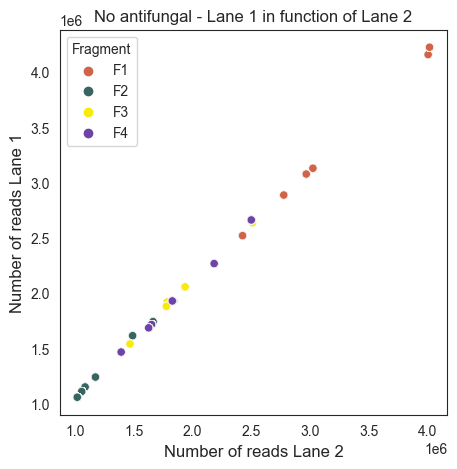

In [10]:
#number of reads after merge
sns.set_style("white")

custom_palette = sns.blend_palette(["#CF6448","#386461","#F6EA0E","#6C44A6"], n_colors=4)
plt.figure(figsize=(5,5))

plt.title(f'{condition} - Lane 1 in function of Lane 2', fontsize=12,y=1)

sns.scatterplot(x=lane2["reads_after_merge"], y=lane1["reads_after_merge"], 
                hue = lane1["Fragment"], legend = True, palette = custom_palette)

#text = "Spearman Coefficient = " + str(round(coeff,2)) + "\nR\u00b2 = " + str(round(R2,2))+ "\np-value = " + str(round(p_value,2))
#plt.text(0.75*1e6, 3*1e6, text , fontsize = 12)

plt.xlabel("Number of reads Lane 2", fontsize=12)
plt.ylabel("Number of reads Lane 1", fontsize =12)

name = "Lane_1_in_function_of_Lane_2_Reads_after_merge_"+ condition + "_" + experiment + "_" + date
plt.savefig(f"c:{name}.png", format='png',  dpi=400)

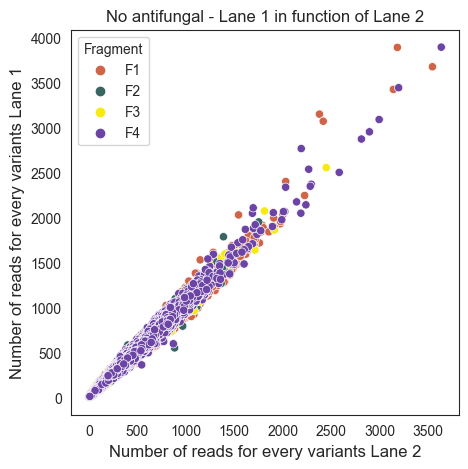

In [11]:
#Frequency of every variant

custom_palette = sns.blend_palette(["#CF6448","#386461","#F6EA0E","#6C44A6"], n_colors=4)
plt.figure(figsize=(5,5))

plt.title(f'{condition} - Lane 1 in function of Lane 2', fontsize=12,y=1)

sns.scatterplot(x=lane2["nbr_reads"], y=lane1["nbr_reads"], 
                hue = lane1["Fragment"], legend = True, palette = custom_palette)

plt.xlabel("Number of reads for every variants Lane 2", fontsize=12)
plt.ylabel("Number of reads for every variants Lane 1", fontsize =12)

name = "Lane_1_in_function_of_Lane_2_Reads_number_" + condition + "_" + experiment + "_" + date
plt.savefig(f"c:{name}.png", format='png',  dpi=400)

In [12]:
#If it looks good we can Sum the lanes

df_group = df.groupby(["Condition","position","codon","Timepoint","Antifungal","Fragment", "Replicate", "OD"])
cols = ["nbr_reads","reads_wanted","reads_before",
        "reads_after_merge","nbr_reads_single", "reads_align","reads_wt"]
df_sum = df_group[cols].sum()

#reset index so the index becomes columns again
df_sum = df_sum.reset_index(level=["Condition","position","codon",
                                   "Timepoint","Antifungal","Fragment", "Replicate","OD"])

df_sum

Condition  position codon  Timepoint Antifungal Fragment  \
0      CaERG11_0_None_F1_1        55   AAA          0       None       F1   
1      CaERG11_0_None_F1_1        55   AAC          0       None       F1   
2      CaERG11_0_None_F1_1        55   AAG          0       None       F1   
3      CaERG11_0_None_F1_1        55   AAT          0       None       F1   
4      CaERG11_0_None_F1_1        55   ACC          0       None       F1   
...                    ...       ...   ...        ...        ...      ...   
48853  CaERG11_3_None_F4_3       511   TGT          3       None       F4   
48854  CaERG11_3_None_F4_3       511   TTA          3       None       F4   
48855  CaERG11_3_None_F4_3       511   TTC          3       None       F4   
48856  CaERG11_3_None_F4_3       511   TTG          3       None       F4   
48857  CaERG11_3_None_F4_3       511   TTT          3       None       F4   

      Replicate        OD  nbr_reads  reads_wanted  reads_before  \
0             1  8.220000     1230.0       7000000       8424407   
1             1  8.220000      903.0       7000000       8424407   
2             1  8.220000     1292.0       7000000       8424407   
3             1  8.220000      726.0       7000000       8424407   
4             1  8.220000      678.0       7000000       8424407   
...         ...       ...        ...           ...           ...   
48853         3  8.291309      746.0       5000000       3377396   
48854         3  8.291309      560.0       5000000       3377396   
48855         3  8.291309      490.0       5000000       3377396   
48856         3  8.291309      776.0       5000000       3377396   
48857         3  8.291309      503.0       5000000       3377396   

       reads_after_merge  nbr_reads_single  reads_align  reads_wt  
0                8167115           2009282      8112927    974119  
1                8167115           2009282      8112927    974119  
2                8167115           2009282      8112927    974119  
3                8167115           2009282      8112927    974119  
4                8167115           2009282      8112927    974119  
...                  ...               ...          ...       ...  
48853            3312559            915475      3251750    441145  
48854            3312559            915475      3251750    441145  
48855            3312559            915475      3251750    441145  
48856            3312559            915475      3251750    441145  
48857            3312559            915475      3251750    441145  

[48858 rows x 15 columns]

C:\Users\CABED117\Anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


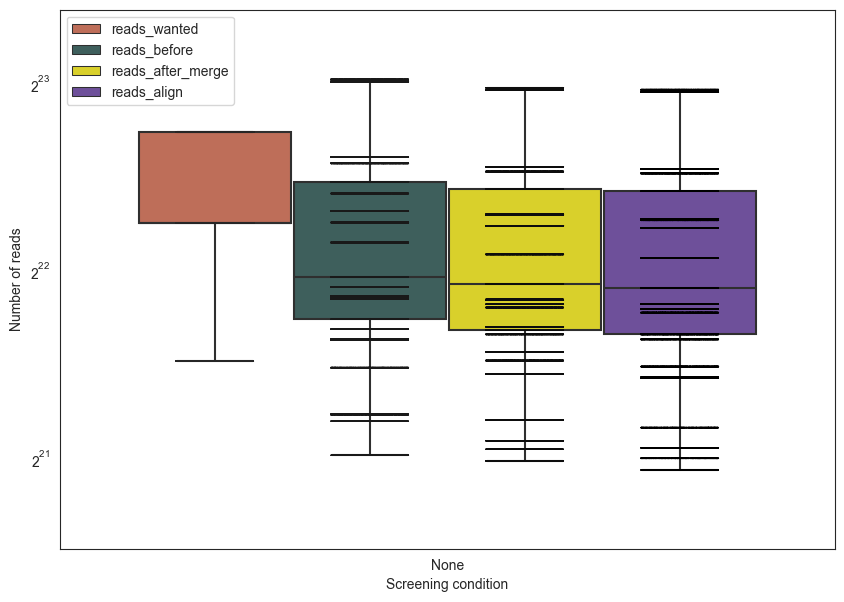

In [13]:
df_melt = pd.melt(df_sum, id_vars=['Antifungal'],value_vars=['reads_wanted', "reads_before",'reads_after_merge',"reads_align"], var_name='Reads control', value_name='Reads')

plt.figure(figsize=(10, 7))
custom_palette = sns.blend_palette(["#CF6448","#386461","#F6EA0E","#6C44A6"], n_colors=4)

ax = sns.boxplot(data=df_melt, x="Antifungal", y="Reads", hue = "Reads control",palette = custom_palette)
ax = sns.stripplot(data=df_melt, x="Antifungal", y="Reads", hue = "Reads control",color="black",dodge=True, jitter=0.2, size=1)

plt.ylim(1500000, 11000000)

plt.yscale('log', base=2)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:4], labels[:4])

plt.xlabel('Screening condition')
plt.ylabel('Number of reads')

plt.show()

In [14]:
#Get the codons in the wt seq

wt_dict = {}
pos = 1

for i in range(0, len(Ca_ERG11), 3):
    codon = Ca_ERG11[i:i + 3]
    wt_dict.update({pos : codon})
    pos = pos+1

In [15]:
# remove wt, they have a count of 0 as they are not variants

ite = 0

for i in df_sum.iterrows() :
    
    first_row = df_sum.loc[ite]
    
    position = first_row['position']
    codon_wt = wt_dict[position]
    
    if first_row['codon'] == codon_wt :

        df_sum = df_sum.drop(ite)
        
    ite = ite+1   
    
df_sum = df_sum.reset_index()
df_sum

index            Condition  position codon  Timepoint Antifungal  \
0          0  CaERG11_0_None_F1_1        55   AAA          0       None   
1          1  CaERG11_0_None_F1_1        55   AAC          0       None   
2          2  CaERG11_0_None_F1_1        55   AAG          0       None   
3          3  CaERG11_0_None_F1_1        55   AAT          0       None   
4          4  CaERG11_0_None_F1_1        55   ACC          0       None   
...      ...                  ...       ...   ...        ...        ...   
47947  48853  CaERG11_3_None_F4_3       511   TGT          3       None   
47948  48854  CaERG11_3_None_F4_3       511   TTA          3       None   
47949  48855  CaERG11_3_None_F4_3       511   TTC          3       None   
47950  48856  CaERG11_3_None_F4_3       511   TTG          3       None   
47951  48857  CaERG11_3_None_F4_3       511   TTT          3       None   

      Fragment Replicate        OD  nbr_reads  reads_wanted  reads_before  \
0           F1         1  8.220000     1230.0       7000000       8424407   
1           F1         1  8.220000      903.0       7000000       8424407   
2           F1         1  8.220000     1292.0       7000000       8424407   
3           F1         1  8.220000      726.0       7000000       8424407   
4           F1         1  8.220000      678.0       7000000       8424407   
...        ...       ...       ...        ...           ...           ...   
47947       F4         3  8.291309      746.0       5000000       3377396   
47948       F4         3  8.291309      560.0       5000000       3377396   
47949       F4         3  8.291309      490.0       5000000       3377396   
47950       F4         3  8.291309      776.0       5000000       3377396   
47951       F4         3  8.291309      503.0       5000000       3377396   

       reads_after_merge  nbr_reads_single  reads_align  reads_wt  
0                8167115           2009282      8112927    974119  
1                8167115           2009282      8112927    974119  
2                8167115           2009282      8112927    974119  
3                8167115           2009282      8112927    974119  
4                8167115           2009282      8112927    974119  
...                  ...               ...          ...       ...  
47947            3312559            915475      3251750    441145  
47948            3312559            915475      3251750    441145  
47949            3312559            915475      3251750    441145  
47950            3312559            915475      3251750    441145  
47951            3312559            915475      3251750    441145  

[47952 rows x 16 columns]

In [16]:
#Now we summed the lanes we can put more info in the df : reads in log and normalized. 
#You have to add +1 to the number of reads if you want to be able to get the log2

df_sum['nbr_reads_log'] = np.log2(df_sum['nbr_reads']+1)
df_sum['norm_reads'] = ((df_sum['nbr_reads']+1) / df_sum['reads_align'])
df_sum['norm_reads_log'] = np.log2(df_sum['norm_reads'])

df_sum=df_sum.reset_index()
df_sum = df_sum.drop("index",axis=1)

name = "Variant_count_Lanes_summed_" + condition + "_" + experiment + "_" + date
df_sum.to_csv(f"c:{name}.csv")  

# 3- Selection coefficient

In [17]:
#open the variants counts with summed lanes

name = "Variant_count_Lanes_summed_" + condition + "_" + experiment + "_" + date + ".csv"
df_v = pd.read_csv(name, header=0, index_col = 0)
df_v

level_0            Condition  position codon  Timepoint Antifungal  \
0            0  CaERG11_0_None_F1_1        55   AAA          0       None   
1            1  CaERG11_0_None_F1_1        55   AAC          0       None   
2            2  CaERG11_0_None_F1_1        55   AAG          0       None   
3            3  CaERG11_0_None_F1_1        55   AAT          0       None   
4            4  CaERG11_0_None_F1_1        55   ACC          0       None   
...        ...                  ...       ...   ...        ...        ...   
47947    47947  CaERG11_3_None_F4_3       511   TGT          3       None   
47948    47948  CaERG11_3_None_F4_3       511   TTA          3       None   
47949    47949  CaERG11_3_None_F4_3       511   TTC          3       None   
47950    47950  CaERG11_3_None_F4_3       511   TTG          3       None   
47951    47951  CaERG11_3_None_F4_3       511   TTT          3       None   

      Fragment  Replicate        OD  nbr_reads  reads_wanted  reads_before  \
0           F1          1  8.220000     1230.0       7000000       8424407   
1           F1          1  8.220000      903.0       7000000       8424407   
2           F1          1  8.220000     1292.0       7000000       8424407   
3           F1          1  8.220000      726.0       7000000       8424407   
4           F1          1  8.220000      678.0       7000000       8424407   
...        ...        ...       ...        ...           ...           ...   
47947       F4          3  8.291309      746.0       5000000       3377396   
47948       F4          3  8.291309      560.0       5000000       3377396   
47949       F4          3  8.291309      490.0       5000000       3377396   
47950       F4          3  8.291309      776.0       5000000       3377396   
47951       F4          3  8.291309      503.0       5000000       3377396   

       reads_after_merge  nbr_reads_single  reads_align  reads_wt  \
0                8167115           2009282      8112927    974119   
1                8167115           2009282      8112927    974119   
2                8167115           2009282      8112927    974119   
3                8167115           2009282      8112927    974119   
4                8167115           2009282      8112927    974119   
...                  ...               ...          ...       ...   
47947            3312559            915475      3251750    441145   
47948            3312559            915475      3251750    441145   
47949            3312559            915475      3251750    441145   
47950            3312559            915475      3251750    441145   
47951            3312559            915475      3251750    441145   

       nbr_reads_log  norm_reads  norm_reads_log  
0          10.265615    0.000152      -12.686176  
1           9.820179    0.000111      -13.131612  
2          10.336507    0.000159      -12.615285  
3           9.505812    0.000090      -13.445980  
4           9.407268    0.000084      -13.544523  
...              ...         ...             ...  
47947       9.544964    0.000230      -12.087820  
47948       9.131857    0.000173      -12.500928  
47949       8.939579    0.000151      -12.693206  
47950       9.601771    0.000239      -12.031014  
47951       8.977280    0.000155      -12.655505  

[47952 rows x 19 columns]

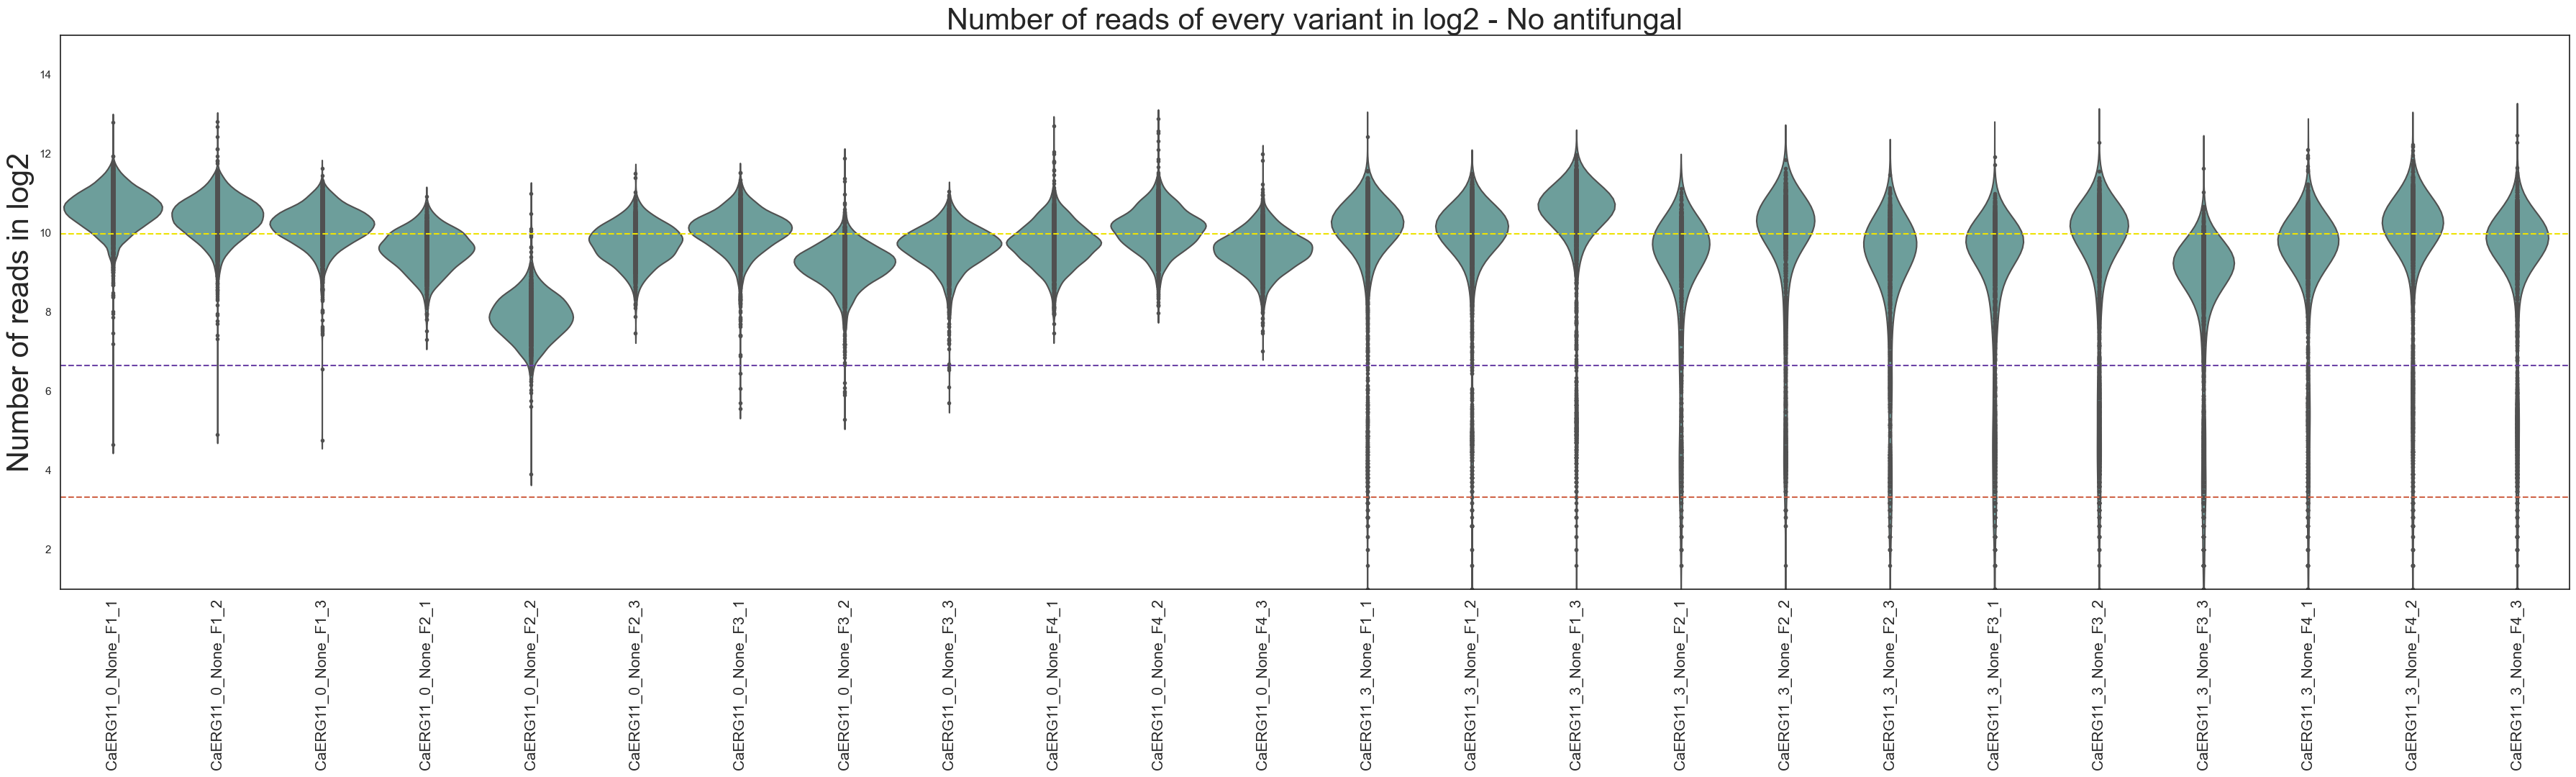

In [18]:

sns.set_style("white")

row = 0
sns.set_theme(style="white", palette=None)
plt.figure(figsize=(45,10))

sns.violinplot(data = df_v, x = 'Condition', y = 'nbr_reads_log',  inner = "point",width=1, color = "#65A6A2")
plt.ylabel("Number of reads in log2",fontsize = 30)
plt.xlabel("")
plt.tick_params(axis="x", labelsize=15, rotation = 90) 
title = condition
plt.title(title, fontsize = 40)
plt.axhline(9.97, color="#EEE304", linestyle="--")
plt.axhline(6.64, color = "#6C44A6", linestyle="--")
plt.axhline(3.32, color = "#D06448", linestyle="--")
plt.ylim(1, 15)


plt.title(f'Number of reads of every variant in log2 - {condition}',y=1, fontsize=30)

name = "./violin_plot_reads_all_log2_lanes_summed_" + condition + "_" + experiment + "_" + date + ".csv"
plt.savefig(f'{name}.png', transparent=True, dpi=400, bbox_inches='tight')

In [19]:
#Get a wide format with reads at every timepoint

#reads norm not in log
df_wide_tp = pd.pivot_table(df_v, index=["position","codon","Antifungal","Fragment", "Replicate"], 
                            columns= "Timepoint", values="norm_reads")

colus = df_sum['Timepoint'].unique()
df_wide_tp=df_wide_tp[colus]

df_wide_tp = df_wide_tp.reset_index(level=["position","codon","Replicate","Antifungal","Fragment"])
df_wide_tp = df_wide_tp.rename(columns={0: 'freq_tp0', 1 : "freq_tp1",
                                        2 : "freq_tp2", 3 : "freq_tp3"}) #remove 3 if no tp3

df_wide_tp

Timepoint  position codon Antifungal Fragment  Replicate  freq_tp0  freq_tp3
0                55   AAA       None       F1          1  0.000152  0.000144
1                55   AAA       None       F1          2  0.000120  0.000138
2                55   AAA       None       F1          3  0.000188  0.000220
3                55   AAC       None       F1          1  0.000111  0.000120
4                55   AAC       None       F1          2  0.000093  0.000108
...             ...   ...        ...      ...        ...       ...       ...
23971           511   TTG       None       F4          2  0.000150  0.000189
23972           511   TTG       None       F4          3  0.000240  0.000239
23973           511   TTT       None       F4          1  0.000137  0.000149
23974           511   TTT       None       F4          2  0.000138  0.000150
23975           511   TTT       None       F4          3  0.000180  0.000155

[23976 rows x 7 columns]

In [20]:
#df wide with raw nbr reads
df_wide_tpnbr = pd.pivot_table(df_v, index=["position","codon","Antifungal","Fragment", "Replicate"],
                               columns= "Timepoint", values="nbr_reads")

colus = df_sum['Timepoint'].unique()
df_wide_tpnbr=df_wide_tpnbr[colus]

df_wide_tpnbr = df_wide_tpnbr.reset_index(level=["position","codon","Replicate","Antifungal","Fragment"])
df_wide_tpnbr = df_wide_tpnbr.rename(columns={0: 'nbr_tp0', 1 : "nbr_tp1",
                                              2 : "nbr_tp2", 3 : "nbr_tp3"}) #remove 3 if no tp3
df_wide_tpnbr

Timepoint  position codon Antifungal Fragment  Replicate  nbr_tp0  nbr_tp3
0                55   AAA       None       F1          1   1230.0    864.0
1                55   AAA       None       F1          2    980.0    777.0
2                55   AAA       None       F1          3    923.0   1343.0
3                55   AAC       None       F1          1    903.0    722.0
4                55   AAC       None       F1          2    758.0    605.0
...             ...   ...        ...      ...        ...      ...      ...
23971           511   TTG       None       F4          2    763.0    829.0
23972           511   TTG       None       F4          3    674.0    776.0
23973           511   TTT       None       F4          1    506.0    494.0
23974           511   TTT       None       F4          2    699.0    658.0
23975           511   TTT       None       F4          3    505.0    503.0

[23976 rows x 7 columns]

In [21]:
#df wide with OD
df_wide_tpod = pd.pivot_table(df_v, index=["position","codon","Antifungal","Fragment", "Replicate"],
                               columns= "Timepoint", values="OD")

colus = df_sum['Timepoint'].unique()
df_wide_tpod=df_wide_tpod[colus]

df_wide_tpod = df_wide_tpod.reset_index(level=["position","codon","Replicate","Antifungal","Fragment"])
df_wide_tpod = df_wide_tpod.rename(columns={0: 'OD_tp0', 1 : "OD_tp1",
                                              2 : "OD_tp2", 3 : "OD_tp3"}) #remove 3 if no tp3
df_wide_tpod

Timepoint  position codon Antifungal Fragment  Replicate  OD_tp0    OD_tp3
0                55   AAA       None       F1          1    8.22  8.137504
1                55   AAA       None       F1          2    8.35  7.653060
2                55   AAA       None       F1          3    7.79  8.065874
3                55   AAC       None       F1          1    8.22  8.137504
4                55   AAC       None       F1          2    8.35  7.653060
...             ...   ...        ...      ...        ...     ...       ...
23971           511   TTG       None       F4          2    7.27  8.224195
23972           511   TTG       None       F4          3    7.20  8.291309
23973           511   TTT       None       F4          1    7.46  8.667466
23974           511   TTT       None       F4          2    7.27  8.224195
23975           511   TTT       None       F4          3    7.20  8.291309

[23976 rows x 7 columns]

In [22]:
#merge wide with frequencies,raw nbrs of reads and od
merged_df = pd.merge(df_wide_tp, df_wide_tpnbr, on=['position', 'codon', "Antifungal", "Fragment", "Replicate"])

merged_df = pd.merge(merged_df, df_wide_tpod, on=['position', 'codon', "Antifungal", "Fragment", 
                                                    "Replicate"])
merged_df

Timepoint  position codon Antifungal Fragment  Replicate  freq_tp0  freq_tp3  \
0                55   AAA       None       F1          1  0.000152  0.000144   
1                55   AAA       None       F1          2  0.000120  0.000138   
2                55   AAA       None       F1          3  0.000188  0.000220   
3                55   AAC       None       F1          1  0.000111  0.000120   
4                55   AAC       None       F1          2  0.000093  0.000108   
...             ...   ...        ...      ...        ...       ...       ...   
23971           511   TTG       None       F4          2  0.000150  0.000189   
23972           511   TTG       None       F4          3  0.000240  0.000239   
23973           511   TTT       None       F4          1  0.000137  0.000149   
23974           511   TTT       None       F4          2  0.000138  0.000150   
23975           511   TTT       None       F4          3  0.000180  0.000155   

Timepoint  nbr_tp0  nbr_tp3  OD_tp0    OD_tp3  
0           1230.0    864.0    8.22  8.137504  
1            980.0    777.0    8.35  7.653060  
2            923.0   1343.0    7.79  8.065874  
3            903.0    722.0    8.22  8.137504  
4            758.0    605.0    8.35  7.653060  
...            ...      ...     ...       ...  
23971        763.0    829.0    7.27  8.224195  
23972        674.0    776.0    7.20  8.291309  
23973        506.0    494.0    7.46  8.667466  
23974        699.0    658.0    7.27  8.224195  
23975        505.0    503.0    7.20  8.291309  

[23976 rows x 11 columns]

In [24]:
#log2foldchange calculation

merged_df['log2(tp3/tp0)'] = np.log2((df_wide_tp["freq_tp3"] / df_wide_tp["freq_tp0"]))

merged_df = merged_df.rename(columns={'log2(tp3/tp0)': 'l2fc_0_3'})

merged_df

Timepoint  position codon Antifungal Fragment  Replicate  freq_tp0  freq_tp3  \
0                55   AAA       None       F1          1  0.000152  0.000144   
1                55   AAA       None       F1          2  0.000120  0.000138   
2                55   AAA       None       F1          3  0.000188  0.000220   
3                55   AAC       None       F1          1  0.000111  0.000120   
4                55   AAC       None       F1          2  0.000093  0.000108   
...             ...   ...        ...      ...        ...       ...       ...   
23971           511   TTG       None       F4          2  0.000150  0.000189   
23972           511   TTG       None       F4          3  0.000240  0.000239   
23973           511   TTT       None       F4          1  0.000137  0.000149   
23974           511   TTT       None       F4          2  0.000138  0.000150   
23975           511   TTT       None       F4          3  0.000180  0.000155   

Timepoint  nbr_tp0  nbr_tp3  OD_tp0    OD_tp3  l2fc_0_3  
0           1230.0    864.0    8.22  8.137504 -0.075307  
1            980.0    777.0    8.35  7.653060  0.206612  
2            923.0   1343.0    7.79  8.065874  0.226799  
3            903.0    722.0    8.22  8.137504  0.111424  
4            758.0    605.0    8.35  7.653060  0.216313  
...            ...      ...     ...       ...       ...  
23971        763.0    829.0    7.27  8.224195  0.330975  
23972        674.0    776.0    7.20  8.291309 -0.004041  
23973        506.0    494.0    7.46  8.667466  0.123453  
23974        699.0    658.0    7.27  8.224195  0.124360  
23975        505.0    503.0    7.20  8.291309 -0.212782  

[23976 rows x 12 columns]

In [25]:
#add the corresponding aa to a list using the dictionary we define at the beginning and add to the df

aa_list = []

for _, row in merged_df.iterrows():
    codon = row['codon']
    aa = DNA_Codons.get(codon)
    aa_list.append(aa)
    
merged_df["aa"] = aa_list
merged_df

Timepoint  position codon Antifungal Fragment  Replicate  freq_tp0  freq_tp3  \
0                55   AAA       None       F1          1  0.000152  0.000144   
1                55   AAA       None       F1          2  0.000120  0.000138   
2                55   AAA       None       F1          3  0.000188  0.000220   
3                55   AAC       None       F1          1  0.000111  0.000120   
4                55   AAC       None       F1          2  0.000093  0.000108   
...             ...   ...        ...      ...        ...       ...       ...   
23971           511   TTG       None       F4          2  0.000150  0.000189   
23972           511   TTG       None       F4          3  0.000240  0.000239   
23973           511   TTT       None       F4          1  0.000137  0.000149   
23974           511   TTT       None       F4          2  0.000138  0.000150   
23975           511   TTT       None       F4          3  0.000180  0.000155   

Timepoint  nbr_tp0  nbr_tp3  OD_tp0    OD_tp3  l2fc_0_3 aa  
0           1230.0    864.0    8.22  8.137504 -0.075307  K  
1            980.0    777.0    8.35  7.653060  0.206612  K  
2            923.0   1343.0    7.79  8.065874  0.226799  K  
3            903.0    722.0    8.22  8.137504  0.111424  N  
4            758.0    605.0    8.35  7.653060  0.216313  N  
...            ...      ...     ...       ...       ... ..  
23971        763.0    829.0    7.27  8.224195  0.330975  L  
23972        674.0    776.0    7.20  8.291309 -0.004041  L  
23973        506.0    494.0    7.46  8.667466  0.123453  F  
23974        699.0    658.0    7.27  8.224195  0.124360  F  
23975        505.0    503.0    7.20  8.291309 -0.212782  F  

[23976 rows x 13 columns]

In [26]:
#Get the codons in the wt seq

wt_dict = {}
pos = 1

for i in range(0, len(Ca_ERG11), 3):
    codon = Ca_ERG11[i:i + 3]
    wt_dict.update({pos : codon})
    pos = pos+1

In [28]:
#open df with wt positions

WT_annot = pd.read_excel('../wt_aa_annot.xlsx', header=0)

aa_wt1 = pd.melt(WT_annot, id_vars=['aa'])

#keep only WT rows

aa_wt1 = aa_wt1[aa_wt1['value'] == 'o'].reset_index(drop=True)

#make a dictionnary of position + wt aa

aa_dict = dict(zip(aa_wt1['variable'], aa_wt1['aa']))

In [29]:
# get all the wts infos in our df

df_wt = merged_df  # Assigning merged_df to df_wt

ite = 0  # Initializing a counter variable

for i in df_wt.iterrows():  # Iterating over the rows of df_wt
    
    first_row = df_wt.loc[ite]  # Accessing the row at index ite
    
    position = first_row['position']  # Extracting the value of 'position' column
    aa_wt = aa_dict[position]  # Getting the corresponding value from wt_dict
    
    if first_row['aa'] != aa_wt:  # Comparing 'codon' value with codon_wt
        
        df_wt = df_wt.drop(ite)  # Dropping the row at index ite
        
    ite = ite + 1  # Incrementing the counter variable
    
df_wt = df_wt.reset_index()
df_wt  # Outputting the filtered DataFrame

Timepoint  index  position codon Antifungal Fragment  Replicate  freq_tp0  \
0             21        55   ATC       None       F1          1  0.000103   
1             22        55   ATC       None       F1          2  0.000101   
2             23        55   ATC       None       F1          3  0.000156   
3             27        55   ATT       None       F1          1  0.000141   
4             28        55   ATT       None       F1          2  0.000125   
..           ...       ...   ...        ...      ...        ...       ...   
799        23965       511   TTA       None       F4          2  0.000132   
800        23966       511   TTA       None       F4          3  0.000180   
801        23970       511   TTG       None       F4          1  0.000168   
802        23971       511   TTG       None       F4          2  0.000150   
803        23972       511   TTG       None       F4          3  0.000240   

Timepoint  freq_tp3  nbr_tp0  nbr_tp3  OD_tp0    OD_tp3  l2fc_0_3 aa  
0          0.000105    834.0    629.0    8.22  8.137504  0.027327  I  
1          0.000098    829.0    550.0    8.35  7.653060 -0.049964  I  
2          0.000150    764.0    915.0    7.79  8.065874 -0.053881  I  
3          0.000158   1140.0    945.0    8.22  8.137504  0.163365  I  
4          0.000155   1026.0    873.0    8.35  7.653060  0.308364  I  
..              ...      ...      ...     ...       ...       ... ..  
799        0.000176    672.0    770.0    7.27  8.224195  0.407561  L  
800        0.000173    505.0    560.0    7.20  8.291309 -0.058205  L  
801        0.000202    622.0    669.0    7.46  8.667466  0.262939  L  
802        0.000189    763.0    829.0    7.27  8.224195  0.330975  L  
803        0.000239    674.0    776.0    7.20  8.291309 -0.004041  L  

[804 rows x 14 columns]

In [30]:
# get all the synonymous wts infos, they are the most representative of wt behaviour as they are in frequencies similar
# to other variants in comparison with wt that is in higher frequency and correspond only to one measure

df_wt_syn = df_wt

ite = 0

for i in df_wt_syn.iterrows() :
    
    first_row = df_wt_syn.loc[ite]
    
    position = first_row['position']
    aa_wt = aa_dict[position]
    codon_wt = wt_dict[position]
    
    if first_row['codon'] == codon_wt :

        df_wt_syn = df_wt_syn.drop(ite)
        print("remove : " + str(position) + codon_wt)
        
    ite = ite+1   
    
df_wt_syn = df_wt_syn.reset_index().drop("index",axis=1).drop("level_0",axis=1)
df_wt_syn

Timepoint  position codon Antifungal Fragment  Replicate  freq_tp0  freq_tp3  \
0                55   ATC       None       F1          1  0.000103  0.000105   
1                55   ATC       None       F1          2  0.000101  0.000098   
2                55   ATC       None       F1          3  0.000156  0.000150   
3                55   ATT       None       F1          1  0.000141  0.000158   
4                55   ATT       None       F1          2  0.000125  0.000155   
..              ...   ...        ...      ...        ...       ...       ...   
799             511   TTA       None       F4          2  0.000132  0.000176   
800             511   TTA       None       F4          3  0.000180  0.000173   
801             511   TTG       None       F4          1  0.000168  0.000202   
802             511   TTG       None       F4          2  0.000150  0.000189   
803             511   TTG       None       F4          3  0.000240  0.000239   

Timepoint  nbr_tp0  nbr_tp3  OD_tp0    OD_tp3  l2fc_0_3 aa  
0            834.0    629.0    8.22  8.137504  0.027327  I  
1            829.0    550.0    8.35  7.653060 -0.049964  I  
2            764.0    915.0    7.79  8.065874 -0.053881  I  
3           1140.0    945.0    8.22  8.137504  0.163365  I  
4           1026.0    873.0    8.35  7.653060  0.308364  I  
..             ...      ...     ...       ...       ... ..  
799          672.0    770.0    7.27  8.224195  0.407561  L  
800          505.0    560.0    7.20  8.291309 -0.058205  L  
801          622.0    669.0    7.46  8.667466  0.262939  L  
802          763.0    829.0    7.27  8.224195  0.330975  L  
803          674.0    776.0    7.20  8.291309 -0.004041  L  

[804 rows x 13 columns]

In [31]:
#wt for every fragment and replicate

wt_frag = df_wt_syn.groupby("Fragment")
f1_wt = wt_frag.get_group("F1").reset_index()
f2_wt = wt_frag.get_group("F2").reset_index()
f3_wt = wt_frag.get_group("F3").reset_index()
f4_wt = wt_frag.get_group("F4").reset_index()

wt_frag1_r = f1_wt.groupby("Replicate")
f1_wt1 = wt_frag1_r.get_group(1).reset_index()
f1_wt2 = wt_frag1_r.get_group(2).reset_index()
f1_wt3 = wt_frag1_r.get_group(3).reset_index()

wt_frag2_r = f2_wt.groupby("Replicate")
f2_wt1 = wt_frag2_r.get_group(1).reset_index()
f2_wt2 = wt_frag2_r.get_group(2).reset_index()
f2_wt3 = wt_frag2_r.get_group(3).reset_index()

wt_frag3_r = f3_wt.groupby("Replicate")
f3_wt1 = wt_frag3_r.get_group(1).reset_index()
f3_wt2 = wt_frag3_r.get_group(2).reset_index()
f3_wt3 = wt_frag3_r.get_group(3).reset_index()

wt_frag4_r = f4_wt.groupby("Replicate")
f4_wt1 = wt_frag4_r.get_group(1).reset_index()
f4_wt2 = wt_frag4_r.get_group(2).reset_index()
f4_wt3 = wt_frag4_r.get_group(3).reset_index()

merged_df["select_coef"] = np.nan #add an empty column to add our selection coefficient
merged_df_frag = merged_df.groupby("Fragment")

m1 = merged_df_frag.get_group("F1")
m1r = m1.groupby("Replicate")
m1_1 = m1r.get_group(1).reset_index()
m1_2 = m1r.get_group(2).reset_index()
m1_3 = m1r.get_group(3).reset_index()

m2 = merged_df_frag.get_group("F2")
m2r = m2.groupby("Replicate")
m2_1 = m2r.get_group(1).reset_index()
m2_2 = m2r.get_group(2).reset_index()
m2_3 = m2r.get_group(3).reset_index()

m3 = merged_df_frag.get_group("F3")
m3r = m3.groupby("Replicate")
m3_1 = m3r.get_group(1).reset_index()
m3_2 = m3r.get_group(2).reset_index()
m3_3 = m3r.get_group(3).reset_index()

m4 = merged_df_frag.get_group("F4")
m4r = m4.groupby("Replicate")
m4_1 = m4r.get_group(1).reset_index()
m4_2 = m4r.get_group(2).reset_index()
m4_3 = m4r.get_group(3).reset_index()

In [32]:
rep_list = [1,2,3]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m1_" + str(r)
    df = globals()[name]
    wt_name = "f1_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp3"]
        
        freq_mut_2 = first_row["freq_tp3"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp3"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df1 = pd.concat(df_list, axis=0)

concatenated_df1 

0.0002243486272777
0.000220587790919
0.00027636873745654996


Timepoint  level_0  index  position codon Antifungal Fragment  Replicate  \
0                0      0        55   AAA       None       F1          1   
1                1      3        55   AAC       None       F1          1   
2                2      6        55   AAG       None       F1          1   
3                3      9        55   AAT       None       F1          1   
4                4     12        55   ACC       None       F1          1   
...            ...    ...       ...   ...        ...      ...        ...   
2832          2832   8930       162   TGT       None       F1          3   
2833          2833   8936       162   TTA       None       F1          3   
2834          2834   8942       162   TTC       None       F1          3   
2835          2835   8948       162   TTG       None       F1          3   
2836          2836   8954       162   TTT       None       F1          3   

Timepoint  freq_tp0  freq_tp3  nbr_tp0  nbr_tp3  OD_tp0    OD_tp3  l2fc_0_3  \
0          0.000152  0.000144   1230.0    864.0    8.22  8.137504 -0.075307   
1          0.000111  0.000120    903.0    722.0    8.22  8.137504  0.111424   
2          0.000159  0.000147   1292.0    881.0    8.22  8.137504 -0.118120   
3          0.000090  0.000090    726.0    542.0    8.22  8.137504  0.012748   
4          0.000084  0.000085    678.0    511.0    8.22  8.137504  0.026484   
...             ...       ...      ...      ...     ...       ...       ...   
2832       0.000181  0.000199    890.0   1217.0    7.79  8.065874  0.137248   
2833       0.000251  0.000294   1231.0   1793.0    7.79  8.065874  0.228408   
2834       0.000257  0.000315   1262.0   1926.0    7.79  8.065874  0.295733   
2835       0.000214  0.000252   1051.0   1536.0    7.79  8.065874  0.233213   
2836       0.000271  0.000314   1329.0   1918.0    7.79  8.065874  0.215159   

Timepoint aa  select_coef   nbr_gen  
0          K    -0.023616  8.137504  
1          N    -0.000668  8.137504  
2          K    -0.028877  8.137504  
3          N    -0.012795  8.137504  
4          T    -0.011107  8.137504  
...       ..          ...       ...  
2832       C    -0.002673  8.065874  
2833       L     0.008629  8.065874  
2834       F     0.016976  8.065874  
2835       L     0.009225  8.065874  
2836       F     0.006986  8.065874  

[8511 rows x 17 columns]

In [33]:
rep_list = [1,2,3]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m2_" + str(r)
    df = globals()[name]
    wt_name = "f2_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp3"]
        
        freq_mut_2 = first_row["freq_tp3"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp3"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df2 = pd.concat(df_list, axis=0)

concatenated_df2 

0.00040573315264675
0.0003858876245718
0.00042257149705415


Timepoint  level_0  index  position codon Antifungal Fragment  Replicate  \
0                0   8067       154   AAA       None       F2          1   
1                1   8073       154   AAC       None       F2          1   
2                2   8079       154   AAG       None       F2          1   
3                3   8085       154   AAT       None       F2          1   
4                4   8091       154   ACC       None       F2          1   
...            ...    ...       ...   ...        ...      ...        ...   
1151          1151  12287       280   TGT       None       F2          3   
1152          1152  12293       280   TTA       None       F2          3   
1153          1153  12299       280   TTC       None       F2          3   
1154          1154  12305       280   TTG       None       F2          3   
1155          1155  12311       280   TTT       None       F2          3   

Timepoint  freq_tp0  freq_tp3  nbr_tp0  nbr_tp3  OD_tp0    OD_tp3  l2fc_0_3  \
0          0.000240  0.000326    522.0    681.0    7.96  8.167719  0.438980   
1          0.000258  0.000348    560.0    729.0    7.96  8.167719  0.435915   
2          0.000279  0.000376    607.0    786.0    7.96  8.167719  0.428312   
3          0.000171  0.000207    371.0    433.0    7.96  8.167719  0.278412   
4          0.000281  0.000356    612.0    745.0    7.96  8.167719  0.339308   
...             ...       ...      ...      ...     ...       ...       ...   
1151       0.000425  0.000486    997.0    975.0    7.56  8.015248  0.193870   
1152       0.000193  0.000193    453.0    387.0    7.56  8.015248 -0.000607   
1153       0.000271  0.000263    634.0    526.0    7.56  8.015248 -0.042925   
1154       0.000250  0.000313    585.0    628.0    7.56  8.015248  0.328188   
1155       0.000229  0.000211    537.0    423.0    7.56  8.015248 -0.117514   

Timepoint aa  select_coef   nbr_gen  
0          K     0.017077  8.167719  
1          N     0.016702  8.167719  
2          K     0.015771  8.167719  
3          N    -0.002582  8.167719  
4          T     0.004874  8.167719  
...       ..          ...       ...  
1151       C    -0.009617  8.015248  
1152       L    -0.033881  8.015248  
1153       F    -0.039160  8.015248  
1154       L     0.007141  8.015248  
1155       F    -0.048466  8.015248  

[3468 rows x 17 columns]

In [34]:
rep_list = [1,2,3]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m3_" + str(r)
    df = globals()[name]
    wt_name = "f3_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp3"]
        
        freq_mut_2 = first_row["freq_tp3"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp3"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df3 = pd.concat(df_list, axis=0)

concatenated_df3 

0.00025174039494365
0.00024574583464765
0.0002102826695461


Timepoint  level_0  index  position codon Antifungal Fragment  Replicate  \
0                0  11646       276   AAA       None       F3          1   
1                1  11652       276   AAC       None       F3          1   
2                2  11658       276   AAG       None       F3          1   
3                3  11664       276   AAT       None       F3          1   
4                4  11670       276   ACC       None       F3          1   
...            ...    ...       ...   ...        ...      ...        ...   
2014          2014  18680       406   TGT       None       F3          3   
2015          2015  18686       406   TTA       None       F3          3   
2016          2016  18692       406   TTC       None       F3          3   
2017          2017  18698       406   TTG       None       F3          3   
2018          2018  18704       406   TTT       None       F3          3   

Timepoint  freq_tp0  freq_tp3  nbr_tp0  nbr_tp3  OD_tp0    OD_tp3  l2fc_0_3  \
0          0.000220  0.000222    863.0    822.0    7.85  8.104337  0.014662   
1          0.000142  0.000097    557.0    359.0    7.85  8.104337 -0.547467   
2          0.000257  0.000216   1009.0    801.0    7.85  8.104337 -0.247880   
3          0.000336  0.000137   1320.0    507.0    7.85  8.104337 -1.293929   
4          0.000262  0.000219   1029.0    811.0    7.85  8.104337 -0.258292   
...             ...       ...      ...      ...     ...       ...       ...   
2014       0.000168  0.000135    603.0    396.0    7.63  8.173927 -0.317618   
2015       0.000308  0.000272   1105.0    800.0    7.63  8.173927 -0.177685   
2016       0.000136  0.000093    489.0    273.0    7.63  8.173927 -0.550814   
2017       0.000270  0.000256    969.0    751.0    7.63  8.173927 -0.079460   
2018       0.000235  0.000179    843.0    525.0    7.63  8.173927 -0.394388   

Timepoint aa  select_coef   nbr_gen  
0          K     0.024183  8.104337  
1          N    -0.045179  8.104337  
2          K    -0.008213  8.104337  
3          N    -0.137285  8.104337  
4          T    -0.009497  8.104337  
...       ..          ...       ...  
2014       C    -0.013845  8.173927  
2015       L     0.003274  8.173927  
2016       F    -0.042374  8.173927  
2017       L     0.015291  8.173927  
2018       F    -0.023237  8.173927  

[6057 rows x 17 columns]

In [36]:
rep_list = [1,2,3]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m4_" + str(r)
    df = globals()[name]
    wt_name = "f4_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp3"]
        
        freq_mut_2 = first_row["freq_tp3"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp3"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df4 = pd.concat(df_list, axis=0)

concatenated_df4 

0.00027923553924379997
0.0002982998503715
0.00029783962481735003


Timepoint  level_0  index  position codon Antifungal Fragment  Replicate  \
0                0  17367       401   AAA       None       F4          1   
1                1  17373       401   AAC       None       F4          1   
2                2  17379       401   AAG       None       F4          1   
3                3  17385       401   AAT       None       F4          1   
4                4  17391       401   ACC       None       F4          1   
...            ...    ...       ...   ...        ...      ...        ...   
1975          1975  23963       511   TGT       None       F4          3   
1976          1976  23966       511   TTA       None       F4          3   
1977          1977  23969       511   TTC       None       F4          3   
1978          1978  23972       511   TTG       None       F4          3   
1979          1979  23975       511   TTT       None       F4          3   

Timepoint  freq_tp0  freq_tp3  nbr_tp0  nbr_tp3  OD_tp0    OD_tp3  l2fc_0_3  \
0          0.000183  0.000201    677.0    666.0    7.46  8.667466  0.134411   
1          0.000350  0.000478   1296.0   1586.0    7.46  8.667466  0.449133   
2          0.000245  0.000297    907.0    984.0    7.46  8.667466  0.275441   
3          0.000173  0.000230    640.0    764.0    7.46  8.667466  0.413145   
4          0.000223  0.000266    824.0    883.0    7.46  8.667466  0.257662   
...             ...       ...      ...      ...     ...       ...       ...   
1975       0.000233  0.000230    655.0    746.0    7.20  8.291309 -0.019656   
1976       0.000180  0.000173    505.0    560.0    7.20  8.291309 -0.058205   
1977       0.000211  0.000151    594.0    490.0    7.20  8.291309 -0.484235   
1978       0.000240  0.000239    674.0    776.0    7.20  8.291309 -0.004041   
1979       0.000180  0.000155    505.0    503.0    7.20  8.291309 -0.212782   

Timepoint aa  select_coef   nbr_gen  
0          K    -0.005347  8.667466  
1          N     0.030964  8.667466  
2          K     0.010924  8.667466  
3          N     0.026812  8.667466  
4          T     0.008873  8.667466  
...       ..          ...       ...  
1975       C    -0.011636  8.291309  
1976       L    -0.016285  8.291309  
1977       F    -0.067668  8.291309  
1978       L    -0.009753  8.291309  
1979       F    -0.034929  8.291309  

[5940 rows x 17 columns]

In [37]:
###### save the df
F1_2_long = pd.concat([concatenated_df1 ,concatenated_df2 ],axis=0)
F3_4_long = pd.concat([concatenated_df3 , concatenated_df4 ],axis=0)
All_concat = pd.concat([F1_2_long, F3_4_long],axis=0)
name = "Select_coeff_log2foldchange_" + condition + "_" + experiment + "_" + date
All_concat.to_csv(f"c:{name}.csv")  

All_concat

Timepoint  level_0  index  position codon Antifungal Fragment  Replicate  \
0                0      0        55   AAA       None       F1          1   
1                1      3        55   AAC       None       F1          1   
2                2      6        55   AAG       None       F1          1   
3                3      9        55   AAT       None       F1          1   
4                4     12        55   ACC       None       F1          1   
...            ...    ...       ...   ...        ...      ...        ...   
1975          1975  23963       511   TGT       None       F4          3   
1976          1976  23966       511   TTA       None       F4          3   
1977          1977  23969       511   TTC       None       F4          3   
1978          1978  23972       511   TTG       None       F4          3   
1979          1979  23975       511   TTT       None       F4          3   

Timepoint  freq_tp0  freq_tp3  nbr_tp0  nbr_tp3  OD_tp0    OD_tp3  l2fc_0_3  \
0          0.000152  0.000144   1230.0    864.0    8.22  8.137504 -0.075307   
1          0.000111  0.000120    903.0    722.0    8.22  8.137504  0.111424   
2          0.000159  0.000147   1292.0    881.0    8.22  8.137504 -0.118120   
3          0.000090  0.000090    726.0    542.0    8.22  8.137504  0.012748   
4          0.000084  0.000085    678.0    511.0    8.22  8.137504  0.026484   
...             ...       ...      ...      ...     ...       ...       ...   
1975       0.000233  0.000230    655.0    746.0    7.20  8.291309 -0.019656   
1976       0.000180  0.000173    505.0    560.0    7.20  8.291309 -0.058205   
1977       0.000211  0.000151    594.0    490.0    7.20  8.291309 -0.484235   
1978       0.000240  0.000239    674.0    776.0    7.20  8.291309 -0.004041   
1979       0.000180  0.000155    505.0    503.0    7.20  8.291309 -0.212782   

Timepoint aa  select_coef   nbr_gen  
0          K    -0.023616  8.137504  
1          N    -0.000668  8.137504  
2          K    -0.028877  8.137504  
3          N    -0.012795  8.137504  
4          T    -0.011107  8.137504  
...       ..          ...       ...  
1975       C    -0.011636  8.291309  
1976       L    -0.016285  8.291309  
1977       F    -0.067668  8.291309  
1978       L    -0.009753  8.291309  
1979       F    -0.034929  8.291309  

[23976 rows x 17 columns]

# 4- Control between replicates

In [38]:
name = "Select_coeff_log2foldchange_" + condition + "_" + experiment + "_" + date + ".csv"
df_r = pd.read_csv(name, header=0, index_col = 0)
df_r = df_r.drop("level_0",axis=1).drop("index",axis=1)

In [39]:
df_pos = df_r.groupby("position")
pos310 = df_pos.get_group(127)
liste = pos310["nbr_tp0"].tolist()
liste

[1349.0,
 2607.0,
 1811.0,
 3004.0,
 1647.0,
 1637.0,
 1963.0,
 515.0,
 2037.0,
 713.0,
 1348.0,
 1782.0,
 1884.0,
 1089.0,
 461.0,
 1276.0,
 1846.0,
 2066.0,
 3385.0,
 1727.0,
 1665.0,
 1621.0,
 1871.0,
 2149.0,
 948.0,
 1208.0,
 850.0,
 975.0,
 1600.0,
 1689.0,
 886.0,
 1089.0,
 1045.0,
 1405.0,
 720.0,
 922.0,
 911.0,
 1207.0,
 2060.0,
 1514.0,
 2543.0,
 1448.0,
 1423.0,
 1673.0,
 397.0,
 1836.0,
 636.0,
 1150.0,
 1656.0,
 1760.0,
 1058.0,
 409.0,
 1183.0,
 1736.0,
 1657.0,
 2824.0,
 1633.0,
 1549.0,
 1406.0,
 1623.0,
 1782.0,
 812.0,
 1183.0,
 735.0,
 823.0,
 1428.0,
 1424.0,
 915.0,
 946.0,
 846.0,
 1204.0,
 708.0,
 759.0,
 815.0,
 927.0,
 1597.0,
 1194.0,
 1955.0,
 1208.0,
 1236.0,
 1334.0,
 262.0,
 1520.0,
 471.0,
 995.0,
 1223.0,
 1433.0,
 786.0,
 317.0,
 903.0,
 1377.0,
 1415.0,
 2163.0,
 1406.0,
 1200.0,
 1142.0,
 1263.0,
 1270.0,
 615.0,
 897.0,
 548.0,
 647.0,
 1049.0,
 1162.0,
 777.0,
 814.0,
 777.0,
 1078.0,
 530.0,
 688.0,
 663.0]

<Axes:xlabel='Replicate', ylabel='Replicate'>

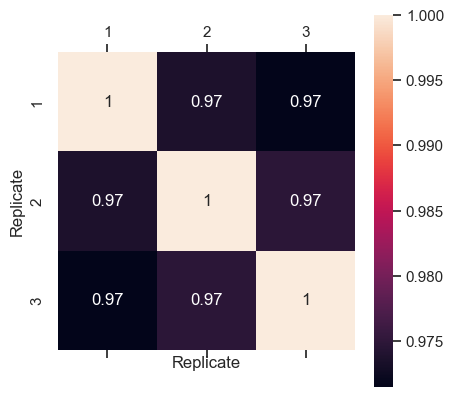

In [40]:
#Correlation condition 1

df_corr = pd.pivot_table(df_r, index=["position","codon","Fragment"], columns= "Replicate", values="select_coef")

colus2 = df_r['Replicate'].unique()
df_corr=df_corr[colus2]

plt.matshow(df_corr.corr())
corr_mat = df_corr.corr()
sns.heatmap(corr_mat, annot=True)

In [41]:
df_r

position codon Antifungal Fragment  Replicate  freq_tp0  freq_tp3  \
0           55   AAA       None       F1          1  0.000152  0.000144   
1           55   AAC       None       F1          1  0.000111  0.000120   
2           55   AAG       None       F1          1  0.000159  0.000147   
3           55   AAT       None       F1          1  0.000090  0.000090   
4           55   ACC       None       F1          1  0.000084  0.000085   
...        ...   ...        ...      ...        ...       ...       ...   
1975       511   TGT       None       F4          3  0.000233  0.000230   
1976       511   TTA       None       F4          3  0.000180  0.000173   
1977       511   TTC       None       F4          3  0.000211  0.000151   
1978       511   TTG       None       F4          3  0.000240  0.000239   
1979       511   TTT       None       F4          3  0.000180  0.000155   

      nbr_tp0  nbr_tp3  OD_tp0    OD_tp3  l2fc_0_3 aa  select_coef   nbr_gen  
0      1230.0    864.0    8.22  8.137504 -0.075307  K    -0.023616  8.137504  
1       903.0    722.0    8.22  8.137504  0.111424  N    -0.000668  8.137504  
2      1292.0    881.0    8.22  8.137504 -0.118120  K    -0.028877  8.137504  
3       726.0    542.0    8.22  8.137504  0.012748  N    -0.012795  8.137504  
4       678.0    511.0    8.22  8.137504  0.026484  T    -0.011107  8.137504  
...       ...      ...     ...       ...       ... ..          ...       ...  
1975    655.0    746.0    7.20  8.291309 -0.019656  C    -0.011636  8.291309  
1976    505.0    560.0    7.20  8.291309 -0.058205  L    -0.016285  8.291309  
1977    594.0    490.0    7.20  8.291309 -0.484235  F    -0.067668  8.291309  
1978    674.0    776.0    7.20  8.291309 -0.004041  L    -0.009753  8.291309  
1979    505.0    503.0    7.20  8.291309 -0.212782  F    -0.034929  8.291309  

[23976 rows x 15 columns]

0.0e+00
0.0e+00
0.0e+00


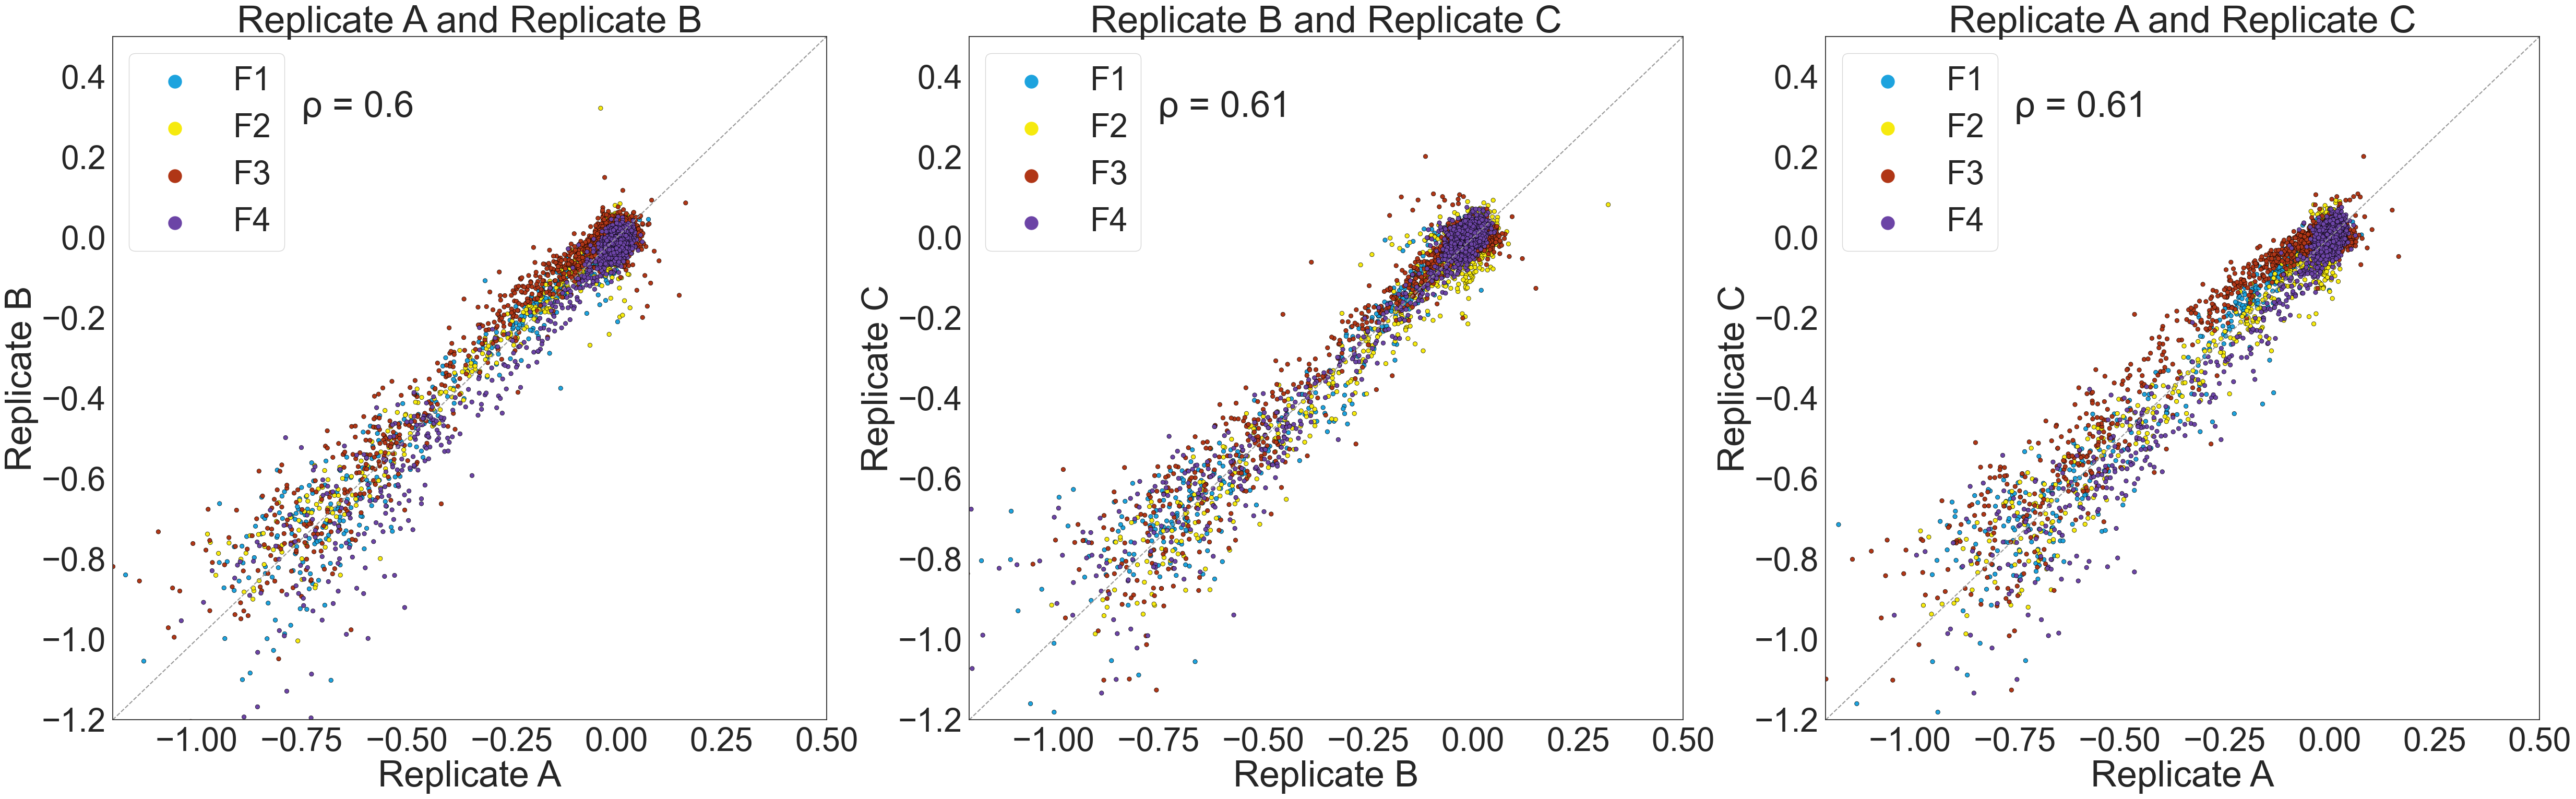

In [42]:
#correlation between replicates

df_r_g = df_r.groupby("Replicate")

r_list = [1,2,1]

r2_list = [2,3,3]

r_lista = ["A","B","A"]

r2_lista = ["B","C","C"]

row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 3, figsize=(60,17))
axes = axes.flatten()
    
for i in range(3) :
    
    sns.set_theme(style="white")
    
    colors = ["#1DA3DE","#F6EA0E","#B03616","#6C44A6"]
    custom_palette = sns.set_palette(sns.color_palette(colors))
    
    rep1 = df_r_g.get_group(r_list[i]).reset_index()
    rep2 = df_r_g.get_group(r2_list[i]).reset_index()
    
    sns.scatterplot(x=rep1["select_coef"],  y=rep2["select_coef"], legend = True, palette = custom_palette,edgecolor="black",  
                    hue = rep1["Fragment"],ax = axes[row])
    
    axes[row].set_ylabel("Replicate " + str(r2_lista[i]), fontsize=50)
    axes[row].set_xlabel("Replicate " + str(r_lista[i]), fontsize=50)
    
    title = "Replicate " + str(r_lista[i]) + " and Replicate " + str(r2_lista[i])
    axes[row].set_title(title, fontsize=52)
    
    axes[row].set_ylim(-1.2, 0.5)
    axes[row].set_xlim(-1.2, 0.5)
    
    axes[row].tick_params(labelsize = 45)
    
    x_vals = np.array([-1.2, 0.5])
    y_vals = x_vals

    # Plot the diagonal line
    axes[row].plot(x_vals, y_vals, '--', color="#989898")
    
    # Increase the size of the legend
    axes[row].legend(fontsize=45, markerscale=3)
    
    result = sp.stats.spearmanr(rep1["select_coef"],rep2["select_coef"])
    coeff = result[0]
    p_value = "{:.1e}".format(result[1])
    R2 = coeff**2     
    print(str(p_value))
    text = "ρ = " + str(round(coeff,2))
    #+ "\np-value = "  + str(p_value)
    axes[row].text(-0.75,0.3, text , fontsize = 50)
        
    row +=1
    
fig.subplots_adjust(hspace=0.31)
#fig.suptitle('Correlation between the Selection coefficient of replicates - ' + condition, y=0.95, fontsize=50)

plt.rcParams['svg.fonttype'] = 'none'
name = "Regression_replicate_select_coeff_" + condition + "_" + experiment + "_" + date
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=300)
plt.savefig(f"c:{name}.svg", format='svg', transparent=True, dpi=300)

In [44]:
#Get the median of the replicates

df_group = df_r.groupby(["position","codon","Antifungal","Fragment","aa"])
cols = ["freq_tp0","freq_tp3","l2fc_0_3","nbr_tp0","nbr_tp3","nbr_gen","select_coef"]
df_med = df_group[cols].median()

#reset index so the index becomes columns again
df_med = df_med.reset_index(level=["position","codon","Antifungal","Fragment","aa"])

name = "Select_coeff_median_replicates_" + condition + "_" + experiment + "_" + date + ".csv"
df_med.to_csv(name)  
df_med

position codon Antifungal Fragment aa  freq_tp0  freq_tp3  l2fc_0_3  \
0           55   AAA       None       F1  K  0.000152  0.000144  0.206612   
1           55   AAC       None       F1  N  0.000111  0.000120  0.111424   
2           55   AAG       None       F1  K  0.000159  0.000152  0.040378   
3           55   AAT       None       F1  N  0.000090  0.000093  0.012748   
4           55   ACC       None       F1  T  0.000084  0.000085  0.238805   
...        ...   ...        ...      ... ..       ...       ...       ...   
7987       511   TGT       None       F4  C  0.000191  0.000230  0.271914   
7988       511   TTA       None       F4  L  0.000132  0.000173  0.145987   
7989       511   TTC       None       F4  F  0.000137  0.000145  0.087906   
7990       511   TTG       None       F4  L  0.000168  0.000202  0.262939   
7991       511   TTT       None       F4  F  0.000138  0.000150  0.123453   

      nbr_tp0  nbr_tp3   nbr_gen  select_coef  
0       980.0    864.0  8.065874    -0.011206  
1       823.0    722.0  8.065874    -0.009938  
2      1111.0    881.0  8.065874    -0.017044  
3       680.0    542.0  8.065874    -0.016186  
4       528.0    511.0  8.065874    -0.006999  
...       ...      ...       ...          ...  
7987    705.0    763.0  8.291309    -0.005653  
7988    505.0    560.0  8.291309    -0.004011  
7989    562.0    490.0  8.291309    -0.014600  
7990    674.0    776.0  8.291309    -0.009753  
7991    506.0    503.0  8.291309    -0.034929  

[7992 rows x 12 columns]

# 5- Control between codons

In [45]:
name = "Select_coeff_median_replicates_" + condition + "_" + experiment + "_" + date + ".csv"
df_c = pd.read_csv(name, header=0, index_col = 0)
df_c

position codon Antifungal Fragment aa  freq_tp0  freq_tp3  l2fc_0_3  \
0           55   AAA       None       F1  K  0.000152  0.000144  0.206612   
1           55   AAC       None       F1  N  0.000111  0.000120  0.111424   
2           55   AAG       None       F1  K  0.000159  0.000152  0.040378   
3           55   AAT       None       F1  N  0.000090  0.000093  0.012748   
4           55   ACC       None       F1  T  0.000084  0.000085  0.238805   
...        ...   ...        ...      ... ..       ...       ...       ...   
7987       511   TGT       None       F4  C  0.000191  0.000230  0.271914   
7988       511   TTA       None       F4  L  0.000132  0.000173  0.145987   
7989       511   TTC       None       F4  F  0.000137  0.000145  0.087906   
7990       511   TTG       None       F4  L  0.000168  0.000202  0.262939   
7991       511   TTT       None       F4  F  0.000138  0.000150  0.123453   

      nbr_tp0  nbr_tp3   nbr_gen  select_coef  
0       980.0    864.0  8.065874    -0.011206  
1       823.0    722.0  8.065874    -0.009938  
2      1111.0    881.0  8.065874    -0.017044  
3       680.0    542.0  8.065874    -0.016186  
4       528.0    511.0  8.065874    -0.006999  
...       ...      ...       ...          ...  
7987    705.0    763.0  8.291309    -0.005653  
7988    505.0    560.0  8.291309    -0.004011  
7989    562.0    490.0  8.291309    -0.014600  
7990    674.0    776.0  8.291309    -0.009753  
7991    506.0    503.0  8.291309    -0.034929  

[7992 rows x 12 columns]

In [46]:
#add the corresponding aa to a list using the dictionary we define at the beginning and add to the df

aa_list = []

for _, row in df_c.iterrows():
    codon = row['codon']
    aa = DNA_Codons.get(codon)
    aa_list.append(aa)
    
df_c["aa"] = aa_list

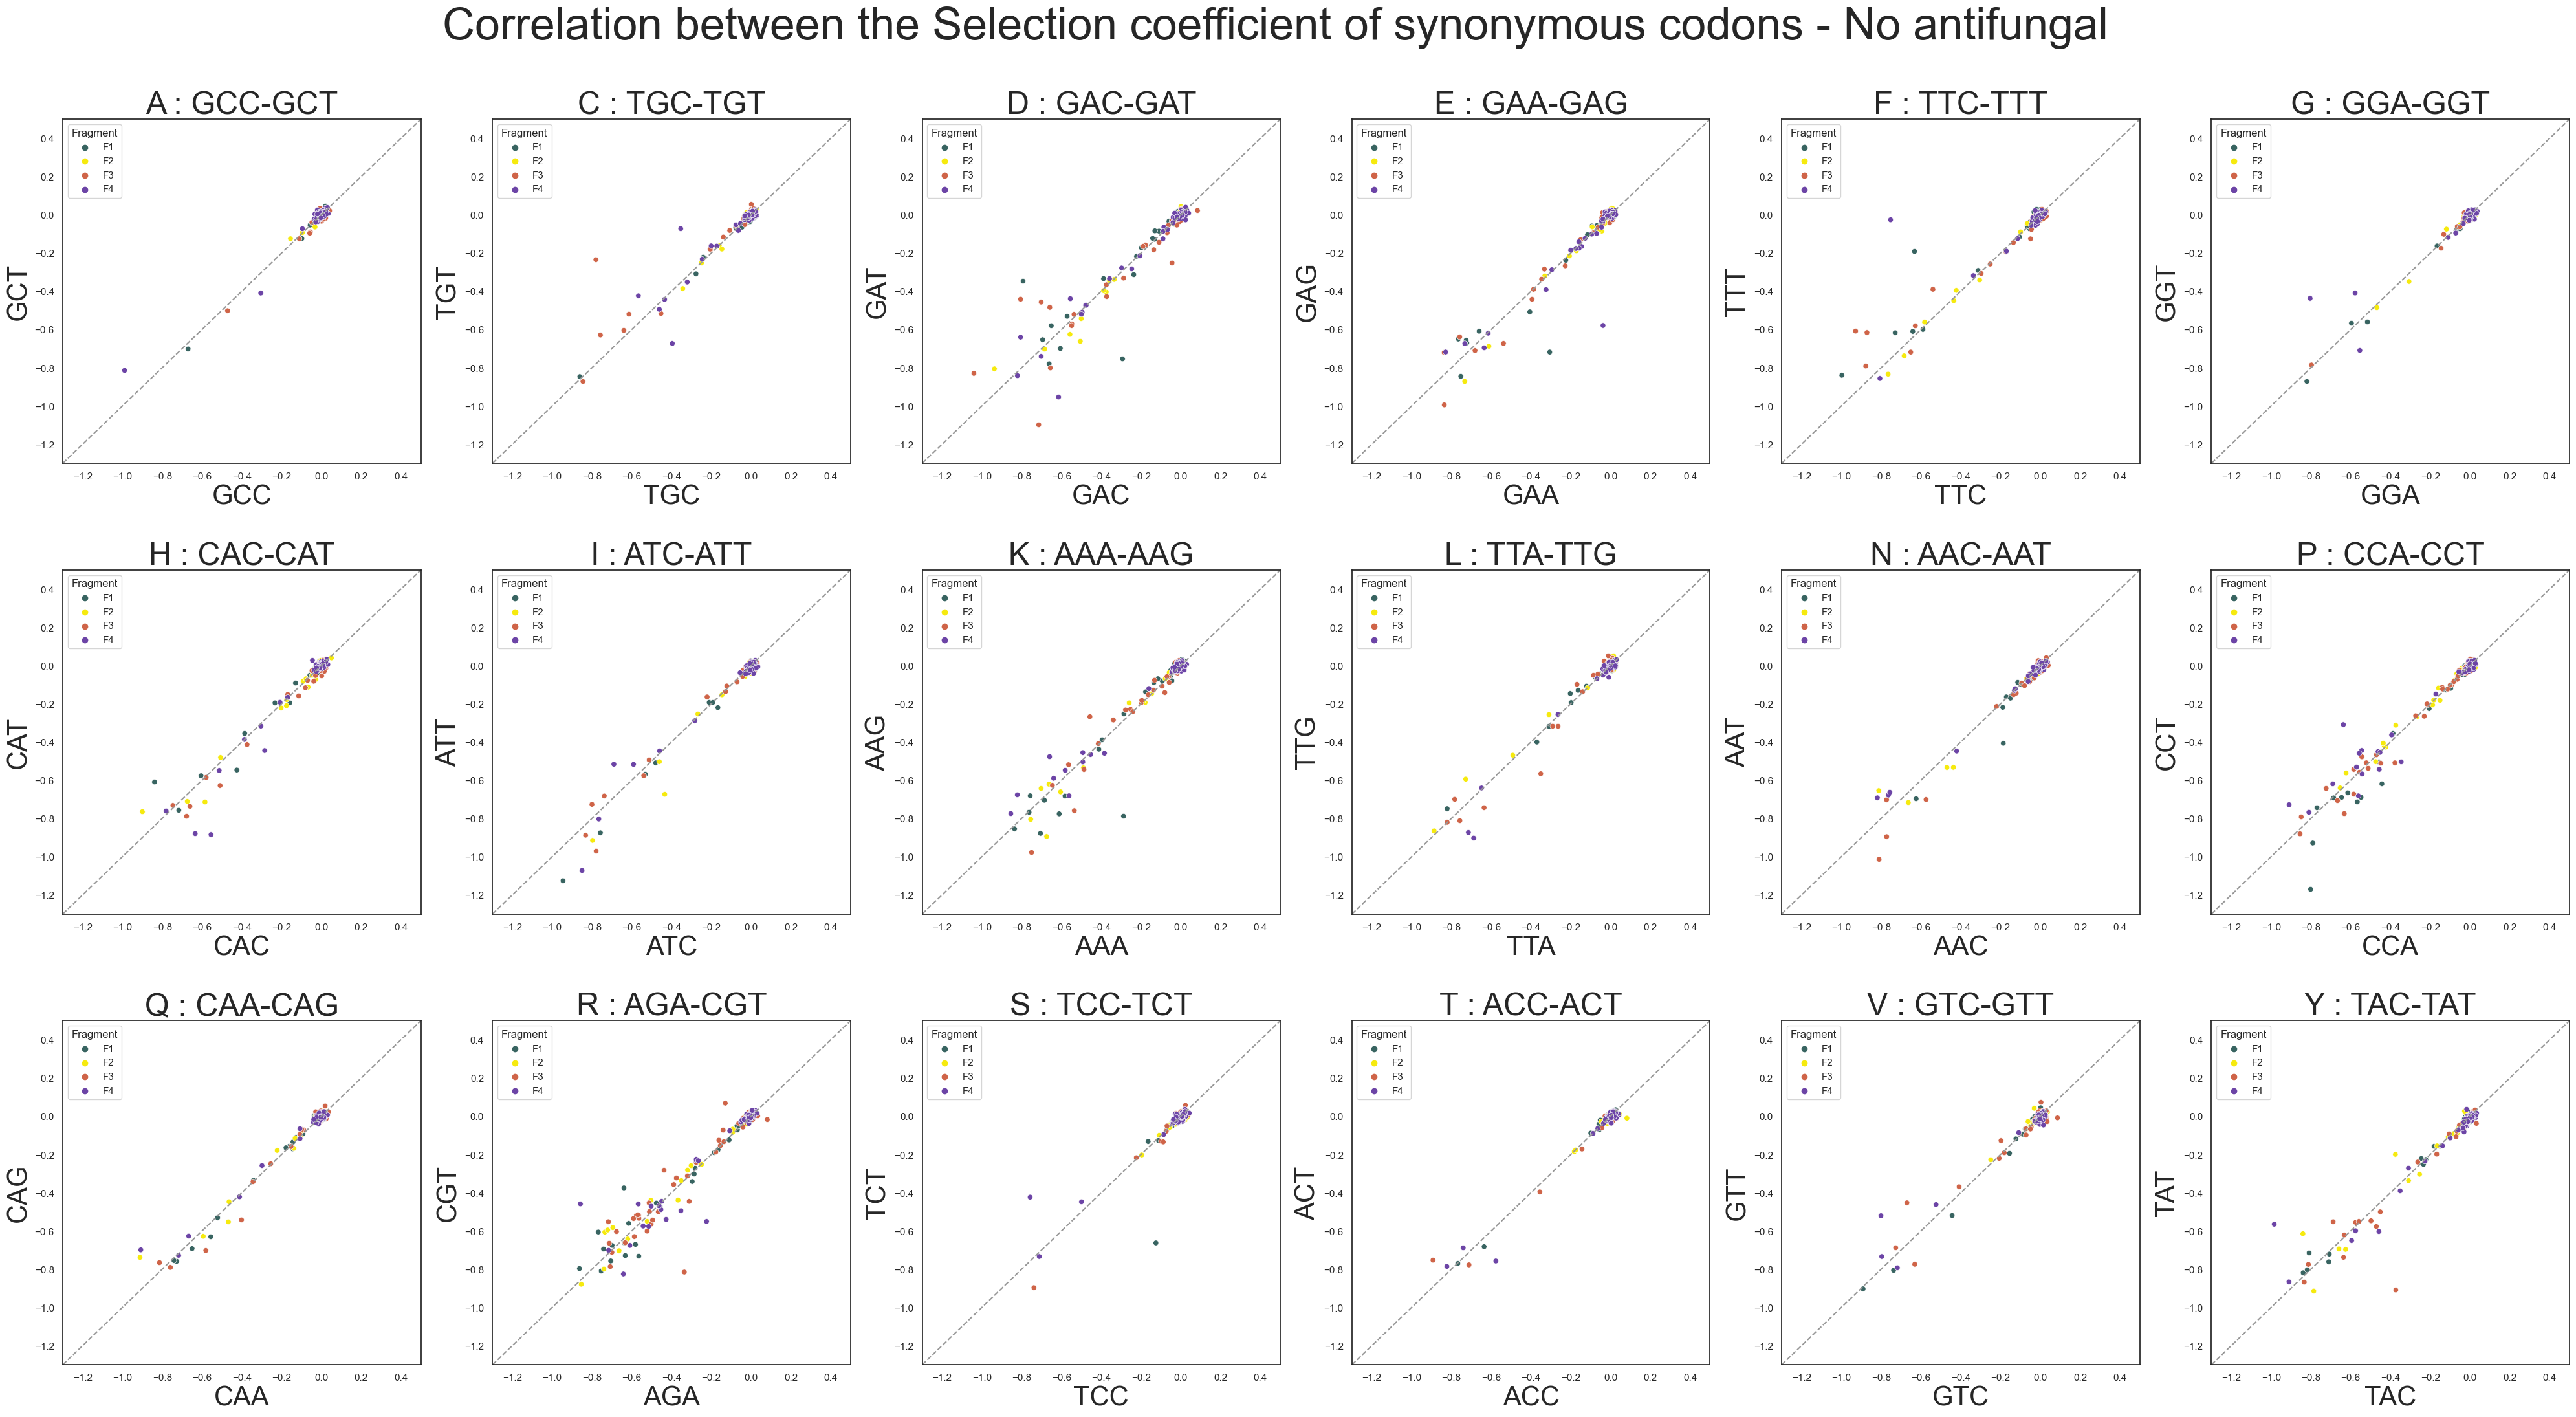

In [47]:
df_co = df_c

# remove wt as they often have only one codon

ite = 0  # Initializing a counter variable

for i in df_co.iterrows():  # Iterating over the rows of df_wt
    
    first_row = df_co.loc[ite]  # Accessing the row at index ite
    
    position = first_row['position']  # Extracting the value of 'position' column
    aa_wt = aa_dict[position]  # Getting the corresponding value from wt_dict
    
    if first_row['aa'] == aa_wt:  # Comparing 'codon' value with codon_wt
        
        df_co = df_co.drop(ite)  # Dropping the row at index ite
        
    ite = ite + 1  # Incrementing the counter variable

df_cod = df_co.groupby(["codon"])
df_aa = df_co.groupby(["aa"])

syn_list = ["A","C","D","E","F","G","H","I","K","L","N","P","Q","R","S","T","V",'Y']

row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(3, 6, figsize=(50,25))
axes = axes.flatten()
    
for aa in syn_list :
    
    sns.set_theme(style="white")
    
    colors = ["#386461","#F6EA0E","#CF6448","#6C44A6"]
    sns.set_palette(sns.color_palette(colors))
    
    amac = df_aa.get_group(aa)
    
    codons = amac['codon'].unique()
    
    cod1 = codons[0]
    cod2 = codons[1]

    cod_df = amac.groupby("codon")
    
    codon1 = cod_df.get_group(cod1).reset_index()
    codon2 = cod_df.get_group(cod2).reset_index()
    
    sns.scatterplot(x = codon1["select_coef"], y = codon2["select_coef"], legend = True, hue = codon1["Fragment"],ax = axes[row])
    axes[row].set_ylabel(cod2, fontsize=30)
    axes[row].set_xlabel(cod1, fontsize=30)
    title = aa + " : " + cod1 + "-" + cod2
    axes[row].set_title(title, fontsize=35)
    axes[row].set_ylim(-1.3, 0.5)
    axes[row].set_xlim(-1.3, 0.5)
    
    x_vals = np.array([-1.3, 0.5])
    y_vals = x_vals

    # Plot the diagonal line
    axes[row].plot(x_vals, y_vals, '--', color="#989898")

    row +=1
    
fig.subplots_adjust(hspace=0.31)
fig.suptitle('Correlation between the Selection coefficient of synonymous codons - ' + condition, y=0.95, fontsize=50)

name = "Correlation_between_synonymous_codons_" + "select_coeff_" + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=400)

In [50]:
# get the mean of every codon

df_group = df_c.groupby(["position","aa","Antifungal","Fragment"])
cols = ["freq_tp0","freq_tp3","l2fc_0_3","nbr_tp0","nbr_tp3","select_coef"]
df_mean = df_group[cols].mean()

#reset index so the index becomes columns again
df_mean = df_mean.reset_index(level=["position","aa","Antifungal","Fragment"])

name = "Selection_coeff_mean_codons_" + condition + "_" + experiment + "_" + date + ".csv"
df_mean.to_csv(name)  

# 6- Control between overlaps

#### We want to verify if the correlation between our overlap is good to see if our results are reproducible and constant.

In [51]:
name = "Selection_coeff_mean_codons_" + condition + "_" + experiment + "_" + date + ".csv"
df_o = pd.read_csv(name, header=0, index_col = 0)

In [52]:
df_o

position aa Antifungal Fragment  freq_tp0  freq_tp3  l2fc_0_3  nbr_tp0  \
0           55  *       None       F1  0.000123  0.000008 -4.101672    913.0   
1           55  A       None       F1  0.000117  0.000128  0.154368    891.0   
2           55  C       None       F1  0.000147  0.000155  0.106087   1054.5   
3           55  D       None       F1  0.000137  0.000107 -0.234875    998.0   
4           55  E       None       F1  0.000170  0.000164  0.020767   1203.0   
...        ... ..        ...      ...       ...       ...       ...      ...   
4277       511  S       None       F4  0.000153  0.000165  0.022656    638.5   
4278       511  T       None       F4  0.000186  0.000201 -0.005525    678.0   
4279       511  V       None       F4  0.000124  0.000140  0.203327    446.0   
4280       511  W       None       F4  0.000176  0.000188  0.090441    652.0   
4281       511  Y       None       F4  0.000156  0.000176  0.015190    688.0   

      nbr_tp3  select_coef  
0        49.0    -0.528211  
1       770.5     0.000422  
2       895.5    -0.009924  
3       636.0    -0.060317  
4       979.0    -0.014490  
...       ...          ...  
4277    619.0    -0.026837  
4278    760.0    -0.021492  
4279    471.5    -0.009377  
4280    610.0    -0.042223  
4281    584.0    -0.030627  

[4282 rows x 10 columns]

(-0.6, 0.2)

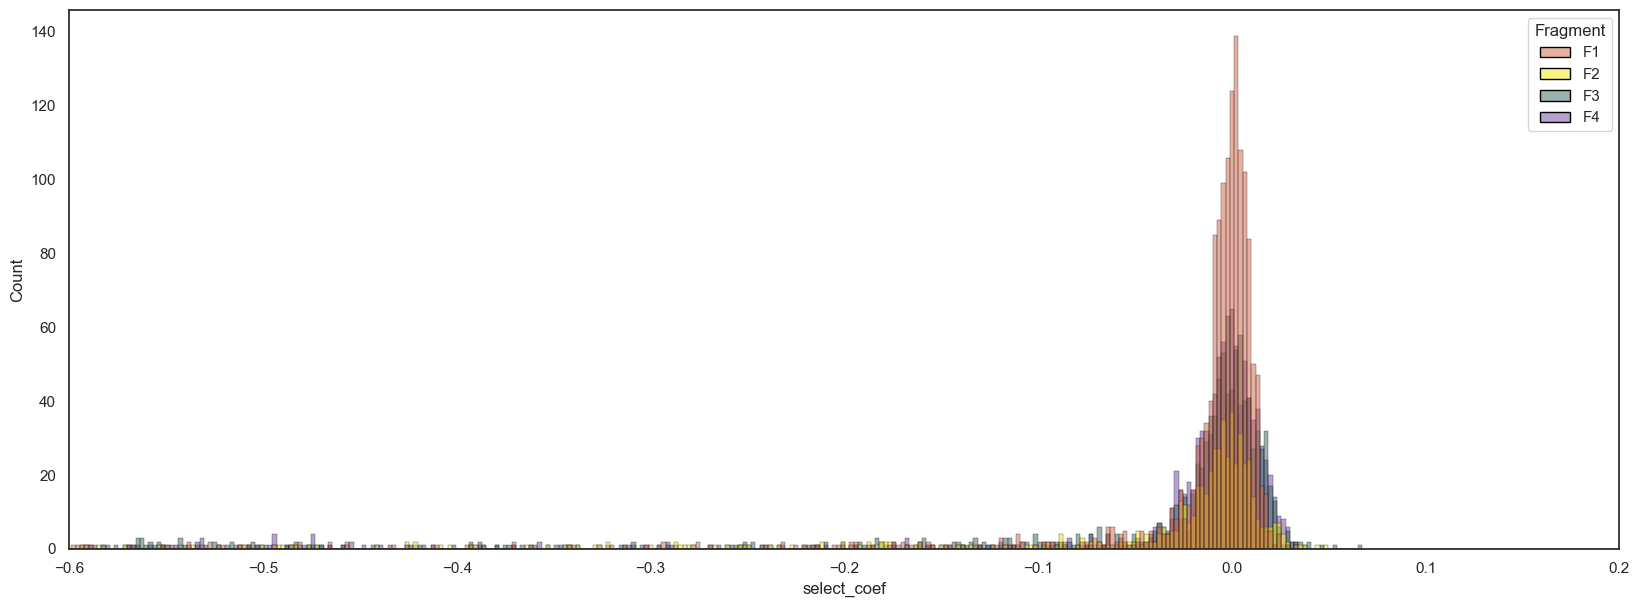

In [53]:
plt.subplots(figsize=(20,7))
custom_palette = sns.blend_palette(["#CF6448","#F6EA0E","#386461","#6C44A6"], n_colors=4)
ax=sns.histplot(data=df_o, x="select_coef", edgecolor="black", hue = "Fragment", palette = custom_palette, bins = 500)
ax.set_xlim(-0.6, 0.2)

#name = "distribution_fluco_select_norm_" + experiment + "_" + date + ".png"
#plt.savefig(name, transparent=True, dpi=600, bbox_inches='tight')

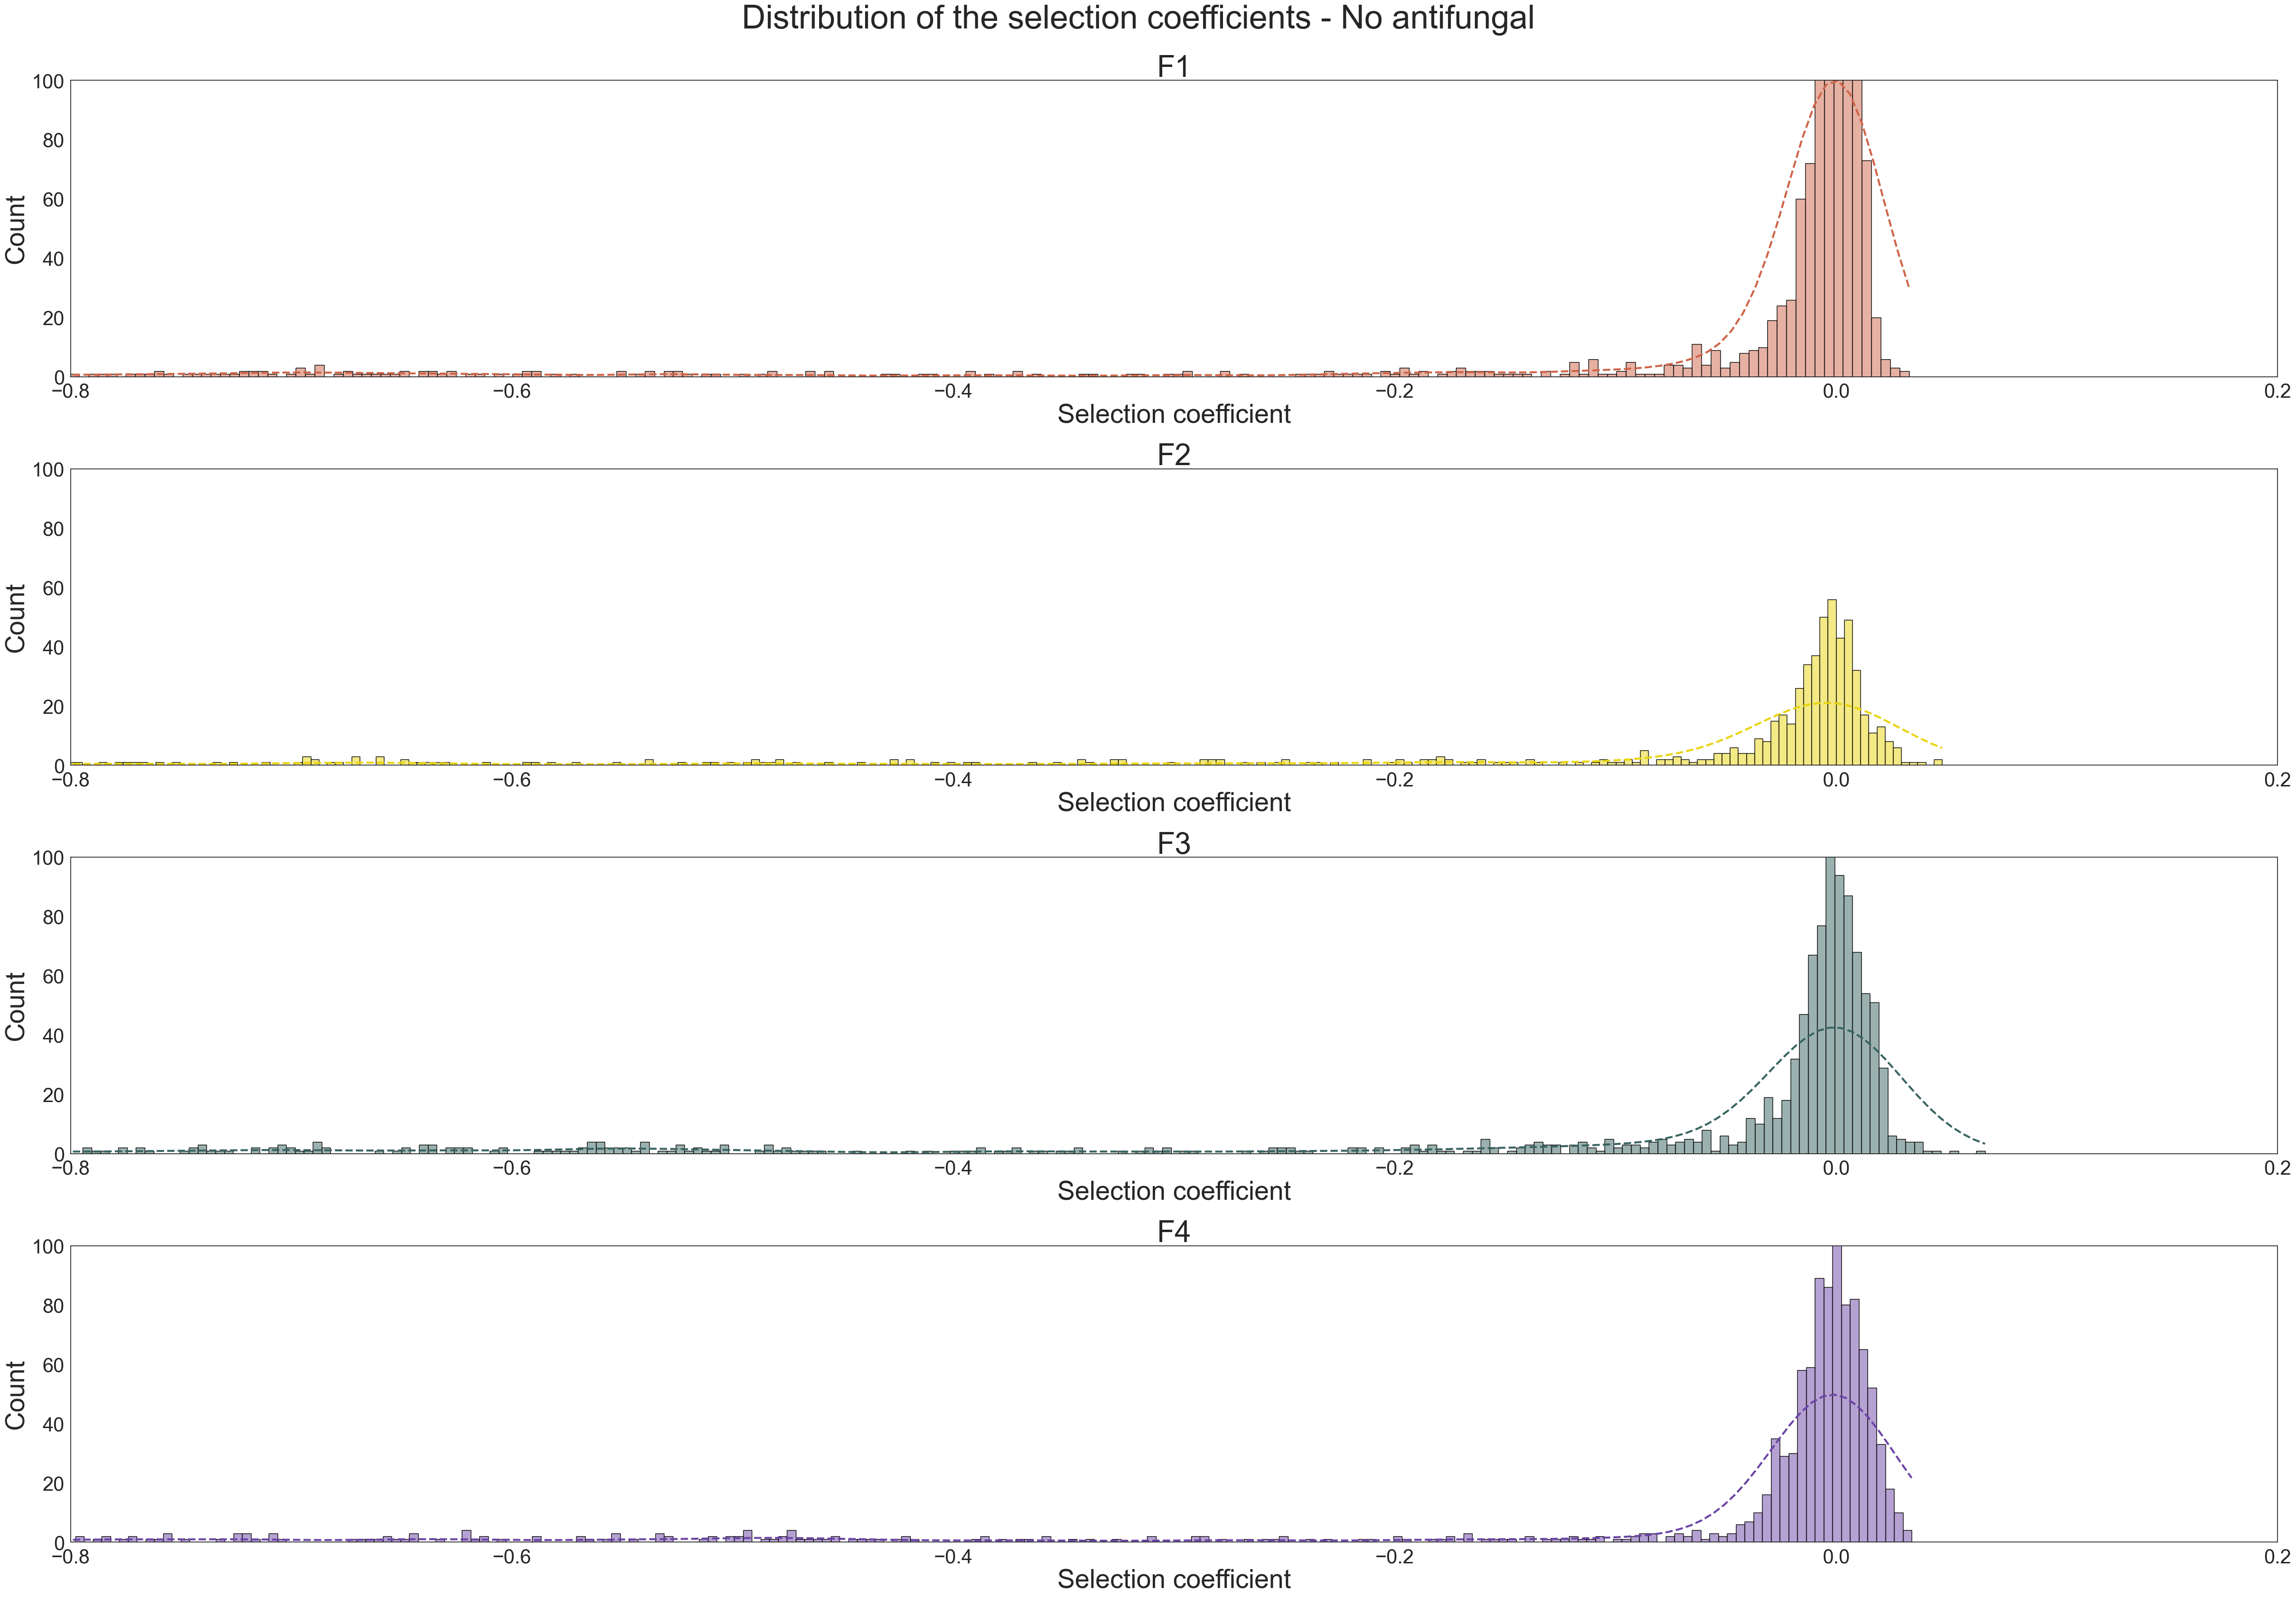

In [54]:
#Distribution of the selection coefficient

df_o_F = df_o.groupby("Fragment")

f_list = ["F1","F2","F3","F4"]
color_list = ["#CF6448","#E9D40D","#386461","#6C44A6"]
row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(4, 1, figsize=(60,40))
axes = axes.flatten()
 
for frag in f_list :
    
    df = df_o_F.get_group(frag)
    
    sns.set_theme(style="white")
    
    sns.histplot(x=df["select_coef"], edgecolor="black", color = color_list[row],  bins = 250,kde=True, kde_kws = {'bw_adjust': 0.5},ax = axes[row], 
                 line_kws = {'linestyle':'dashed','linewidth':'3'}).lines[0].set_color(color_list[row])

    axes[row].set_ylim(0, 100)
    axes[row].set_xlim(-0.8, 0.2)
    
    axes[row].set_ylabel("Count",fontsize=40)
    axes[row].set_xlabel("Selection coefficient",fontsize=40)
    
    axes[row].set_title(frag, fontsize=45)
    
    axes[row].tick_params(labelsize = 30)  
    
    row += 1
    
fig.subplots_adjust(hspace=0.31)
fig.suptitle('Distribution of the selection coefficients - ' + condition, y=0.92, fontsize=50)

name = "Distribution_of_the_selection_coefficient_"  + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=400)

Text(0.5, 1.0, 'sc')

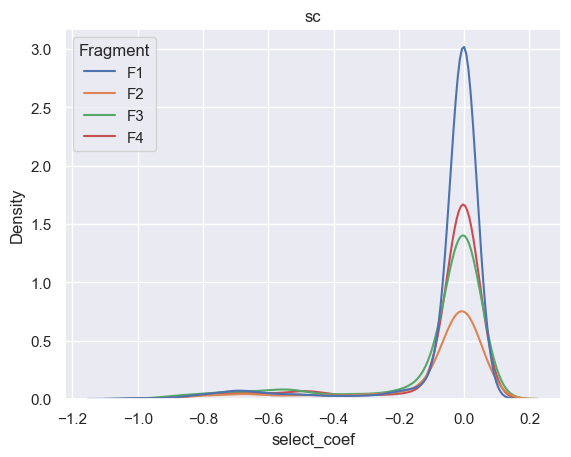

In [55]:
sns.set_style("white")
sns.set(rc={'figure.facecolor':'white'})
sns.kdeplot(data=df_o, x="select_coef", hue="Fragment")
plt.title("sc")

In [56]:
#put rows in overlaps in a new df

df_new = pd.DataFrame(columns=["index", 'position', 'aa', 'Antifungal', 'Fragment', "l2fc_0_2", "l2fc_0_3", "select_coef", "l2fc_0_2_norm", "l2fc_0_3_norm", "select_coef_norm"])

for _, row in df_o.iterrows():
    position = row['position']
    fragment = row['Fragment']
    
    if position in f3_f4_over and fragment == "F3":
        row['Fragment'] = "F3_4"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in f2_f3_over and fragment == "F2":
        row['Fragment'] = "F2_3"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in f2_f3_over and fragment == "F3":
        row['Fragment'] = "F3_2"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in f1_f2_over and fragment == "F2":
        row['Fragment'] = "F2_1"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in over_list:
        df_new = df_new.append(row, ignore_index=True)
        
df_new = df_new.reset_index().drop("index",axis=1).drop("level_0",axis=1)

C:\Users\CABED117\AppData\Local\Temp\ipykernel_22192\2685448605.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_index=True)
C:\Users\CABED117\AppData\Local\Temp\ipykernel_22192\2685448605.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_index=True)
C:\Users\CABED117\AppData\Local\Temp\ipykernel_22192\2685448605.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_index=True)
C:\Users\CABED117\AppData\Local\Temp\ipykernel_22192\2685448605.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_

In [57]:
df_group = df_new.groupby(["Fragment"])

f1 = df_group.get_group("F1").reset_index()
f2_1 = df_group.get_group("F2_1").reset_index()
f2_3 = df_group.get_group("F2_3").reset_index()
f3_2 = df_group.get_group("F3_2").reset_index()
f3_4 = df_group.get_group("F3_4").reset_index()
f4 = df_group.get_group("F4").reset_index()

(-1.0, 0.6)

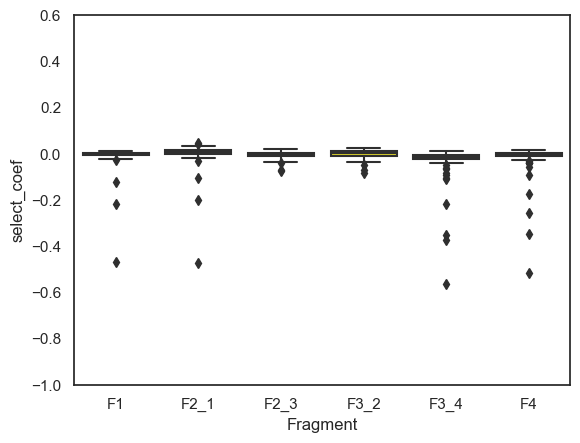

In [58]:
sns.set_theme(style="white")

custom_palette = sns.blend_palette(["#CF6448","#CF6448","#F6EA0E","#F6EA0E","#386461","#386461"], n_colors=6)
sns.boxplot(data= df_new, x= "Fragment", y = "select_coef", palette = custom_palette)
plt.ylim(-1, 0.6)

#name = "Boxplot_overlaps_med_fluco_l2fc02_"  + experiment + "_" + date 
#plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=400)

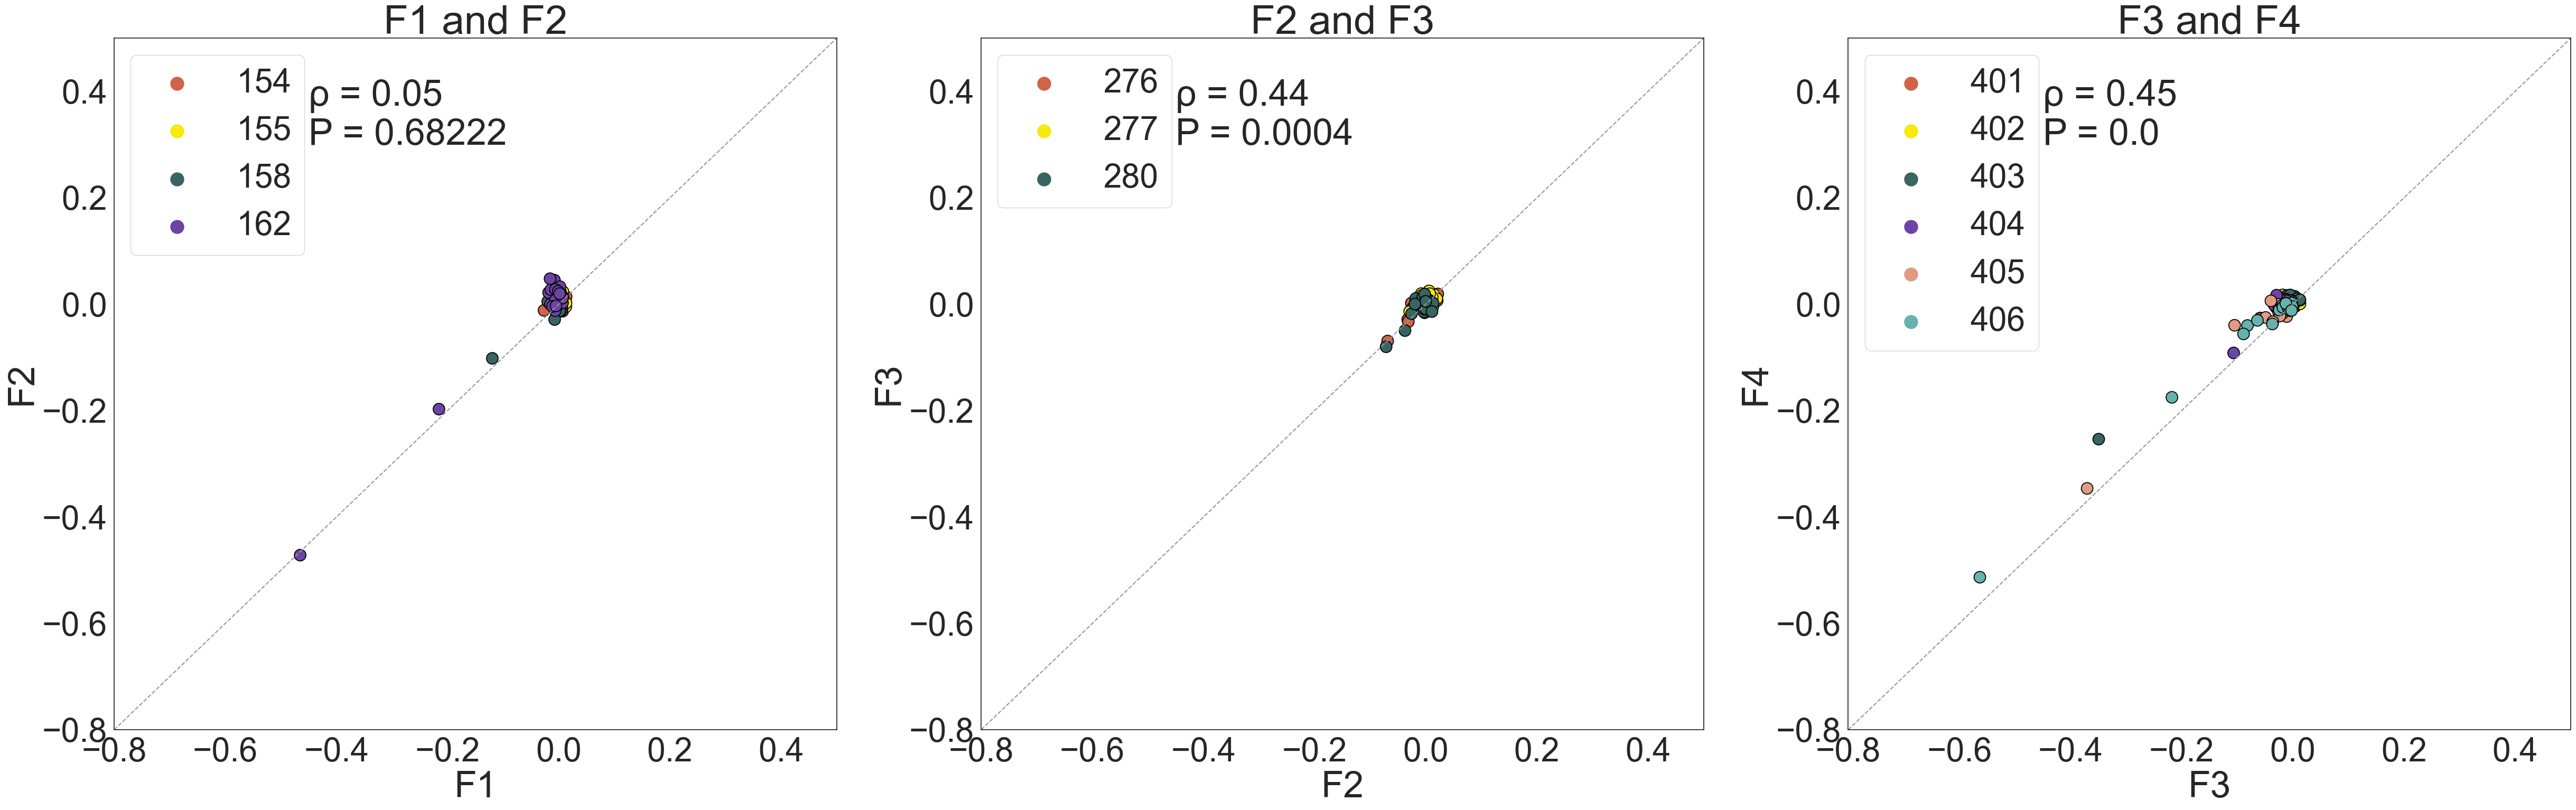

In [60]:
#correlation between replicates

df_r_g = df_r.groupby("Replicate")

o1_list = ["f1","f2_3","f3_4"]

o2_list = ["f2_1","f3_2","f4"]

title_name = ["F1 and F2","F2 and F3","F3 and F4"]
x_name = ["F1", "F2", "F3"]
y_name = ["F2", "F3", "F4"]

row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 3, figsize=(60,17))
axes = axes.flatten()
    
for i in range(len(o1_list)) :
    
    name1 = o1_list[i]
    df1 = globals()[name1]
    
    name2 = o2_list[i]
    df2 = globals()[name2]
    
    sns.set_theme(style="white")
    
    custom_palette = sns.color_palette(["#CF6448","#F6EA0E","#386461","#6C44A6","#E29B82","#64B3AC"], n_colors=len(df1["position"].unique()))
    
    sns.scatterplot(x=df1["select_coef"],  y=df2["select_coef"], legend = True, palette = custom_palette,edgecolor="black",  
                    hue = df1["position"],s = 250, ax = axes[row])    
    
    axes[row].set_ylabel(y_name[i], fontsize=50)
    axes[row].set_xlabel(x_name[i], fontsize=50)
    
    axes[row].set_title(title_name[i], fontsize=55)
    
    axes[row].set_ylim(-0.8, 0.5)
    axes[row].set_xlim(-0.8, 0.5)
    
    axes[row].tick_params(labelsize = 45)
    
    x_vals = np.array([-0.8, 0.5])
    y_vals = x_vals
    
    result = sp.stats.spearmanr(df1["select_coef"],df2["select_coef"])
    coeff = result[0]
    p_value = result[1]
    R2 = coeff**2 
    
    text = "ρ = " + str(round(coeff, 2)) + "\nP = " + str(round(p_value, 5))
    axes[row].text(-0.45,0.3, text , fontsize = 50)

    # Plot the diagonal line
    axes[row].plot(x_vals, y_vals, '--', color="#989898")
    
    # Increase the size of the legend
    axes[row].legend(fontsize=45, markerscale=3)
        
    row +=1
    
fig.subplots_adjust(hspace=0.31)



plt.rcParams['svg.fonttype'] = 'none'
name = "Overlap_select_coef_"  + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=300)
plt.savefig(f"c:{name}.svg", format='svg', transparent=True, dpi=300)

In [62]:
#Getting the means of the overlapping positions

#norm_df = norm_df.drop('Fragment', axis=1)

df_group = df_o.groupby(["position","aa","Antifungal"])
cols = [ "select_coef"]
df_mean = df_group[cols].mean()

#reset index so the index becomes columns again
df_mean = df_mean.reset_index(level=["position","aa","Antifungal"])

name = "Select_coeff_mean_overlap_" + condition + "_" + experiment + "_" + date + ".csv"
df_mean.to_csv(name) 

# 7- Heatmaps !!

In [63]:
name = "Select_coeff_mean_overlap_" + condition + "_" + experiment + "_" + date + ".csv"
df_f = pd.read_csv(name, header=0, index_col = 0)

In [64]:
WT_annot = pd.read_excel('../wt_aa_annot.xlsx', header=0, index_col = 0)

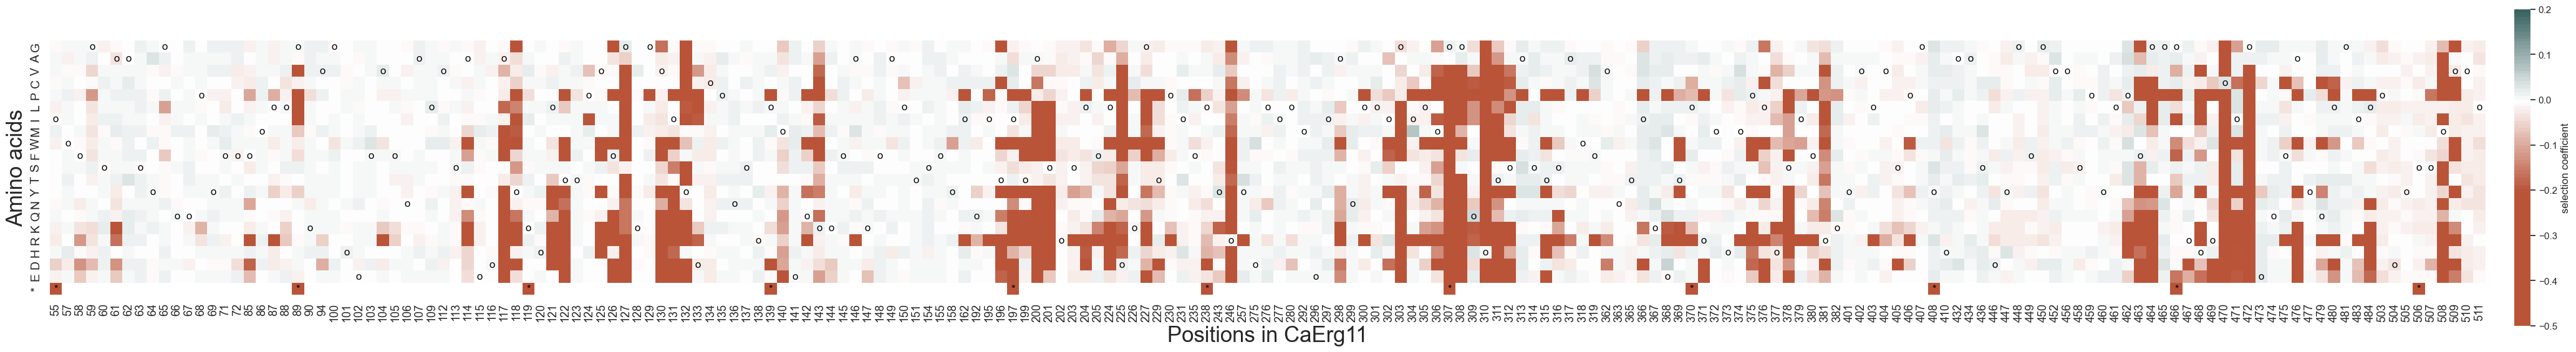

In [66]:
heat = pd.pivot_table(df_f, index="aa", columns= "position", values="select_coef")

heat = heat.reindex(index = ["G","A","V","C","P","L","I","M","W","F","S","T","Y","N","Q","K","R","H","D","E","*"])

custom_palette = sns.blend_palette(["#B95439","#B95439","#B95439","#FFFFFF","#386461"], n_colors=101)

plt.subplots(figsize=(60,60))
sns.set(rc={'figure.facecolor':'white'})
#sns.set(font_scale=1.5)

sns.heatmap(heat, xticklabels="auto", yticklabels=True, annot=False, cmap = custom_palette, 
            robust = True,square=True, vmin=-0.5, vmax=0.2,center=-0.2, 
            cbar_kws={"shrink": 0.11,"pad": 0.01,'label': 'selection coefficient'})

plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=13)

for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        if WT_annot.iloc[i, j] == "o" or WT_annot.iloc[i, j] == "*":
            plt.text(j + 0.5, i + 0.5, WT_annot.iloc[i, j], ha='center', va='center', fontsize=12, color='black')
        
#titre = f"Selection coefficients - {condition} Screening - Library Erg11 of " + '$\it{Candida}$' +" "+ '$\it{albicans}$'

#plt.title(titre, fontsize =30)

plt.xlabel('Positions in CaErg11', fontsize = 25)
plt.ylabel('Amino acids', fontsize = 25)

plt.rcParams['svg.fonttype'] = 'none'
name = "Heatmap_" + "select_coef_" + condition + "_" +experiment + "_" + date + ".png"
plt.savefig(name, transparent=True, dpi=750,format='png', bbox_inches='tight')
name = "Heatmap_" + "select_coef_" + condition + "_" +experiment + "_" + date + ".svg"
plt.savefig(name, transparent=True, dpi=300,format='svg', bbox_inches='tight')

# 9- t-test significant resistance

In [67]:
df_t = pd.read_csv("Select_coeff_log2foldchange_No antifungal_NovaSeq_winter2023_albicans_"+date+".csv", header=0)

In [68]:
# Add a new column with the translation
df_t['aa'] = df_t['codon'].map(DNA_Codons)
df_t['DNA_variant'] =df_t['position'].astype(str) + df_t['codon']
df_t['aa_variant'] =df_t['position'].astype(str) + df_t['aa']

In [69]:
Ca_ERG11 = "ATGGCCATTGTTGAAACGGTAATAGATGGAATCAACTATTTTTTATCACTGTCTGTAACTCAACAAATTAGTATATTACTAGGGGTCCCGTTTGTGTACAATCTGGTTTGGCAGTATTTATATAGTCTAAGAAAAGATAGAGCACCCCTGGTATTCTATTGGATACCCTGGTTCGGCTCAGCAGCGTCTTATGGTCAACAACCGTATGAATTTTTTGAGTCATGCAGGCAGAAATATGGCGATGTTTTTTCCTTTATGCTTCTTGGGAAAATAATGACTGTGTACCTTGGCCCAAAGGGTCACGAATTTGTCTTCAATGCGAAGTTAAGCGATGTCTCTGCTGAAGATGCATACAAACACTTAACAACTCCGGTATTCGGAAAGGGAGTTATCTACGATTGTCCCAACAGTCGTCTGATGGAGCAGAAAAAGTTTGCTAAATTCGCGCTTACTACGGACTCATTCAAAAGGTATGTACCCAAAATTCGTGAAGAAATATTAAACTATTTCGTAACAGACGAAAGTTTCAAATTAAAGGAAAAGACACACGGCGTGGCTAACGTGATGAAAACACAACCTGAAATCACCATTTTTACCGCCAGCAGGTCCTTATTTGGCGACGAGATGAGAAGAATTTTCGATAGAAGTTTTGCTCAACTGTACTCAGATTTGGATAAAGGTTTTACTCCGATAAATTTCGTGTTCCCAAACCTTCCTTTGCCACACTATTGGAGAAGAGATGCTGCACAAAAGAAGATAAGTGCGACCTATATGAAAGAGATAAAATCCCGTAGGGAAAGGGGTGACATTGACCCTAACAGAGACTTGATTGATTCTCTGCTGATTCATAGCACATACAAAGACGGTGTGAAGATGACCGACCAGGAGATTGCAAACCTGCTTATAGGTATTTTAATGGGTGGACAGCACACATCAGCTTCTACGTCAGCATGGTTTCTGCTACACCTGGGGGAAAAACCGCACCTACAAGACGTAATATATCAAGAGGTGGTGGAGTTACTAAAAGAGAAAGGAGGCGATCTAAACGATTTAACCTATGAGGATCTGCAAAAATTGCCGTCAGTCAACAACACGATCAAGGAAACGCTAAGGATGCACATGCCTCTACACAGTATATTCAGAAAAGTTACTAACCCACTTAGGATCCCTGAAACCAACTACATCGTCCCAAAAGGACACTACGTTCTTGTCAGCCCAGGCTACGCACACACGAGTGAGAGATACTTTGATAACCCGGAGGATTTTGATCCTACACGTTGGGATACTGCTGCAGCCAAAGCCAATTCTGTAAGCTTTAACTCCAGTGATGAGGTAGATTACGGCTTTGGGAAAGTATCAAAAGGCGTCAGCTCACCATATCTTCCCTTCGGTGGCGGTAGACATAGATGTATAGGTGAACAATTTGCATACGTTCAGCTGGGAACCATATTAACGACGTTTGTTTATAACTTGAGATGGACTATCGACGGGTATAAAGTCCCTGATCCTGACTATAGCTCTATGGTTGTTctaCCCACCGAACCGGCTGAAATAATTTGGGAGAAAAGAGAGACATGTATGTTTTGA"

#Get the codons in the wt seq

wt_dict = {}
pos = 1

for i in range(0, len(Ca_ERG11), 3):
    codon = Ca_ERG11[i:i + 3]
    wt_dict.update({pos : codon})
    pos = pos+1

In [70]:
# get all the wts infos in our df

df_wt = df_t  # Assigning merged_df to df_wt

ite = 0  

for i in df_wt.iterrows():  # Iterating over the rows of df_wt
    
    first_row = df_wt.loc[ite]  # Accessing the row at index ite
    
    position = first_row['position']  # Extracting the value of 'position' column
    aa_wt = aa_dict[position]  # Getting the corresponding value from wt_dict
    
    if first_row['aa'] != aa_wt:  # Comparing 'codon' value with codon_wt
        
        df_wt = df_wt.drop(ite)  # Dropping the row at index ite
        
    else :   
        df_t.loc[ite,"aa_variant"] = "WT"
        
    ite = ite + 1  
    
df_wt = df_wt.drop("level_0",axis=1).reset_index()

In [71]:
# Perform t-tests for each variant
variants = df_t['aa_variant'].unique()
results = []

for variant in variants:
    variant_data = df_t[df_t['aa_variant'] == variant]

    anti_data = variant_data[variant_data['Antifungal'] == cond]['select_coef']
    wt_data = df_t[df_t['aa_variant'] == 'WT']['select_coef']
    t_stat, p_value = ttest_ind(anti_data, wt_data)
    
    results.append((variant, p_value))

# Apply FDR correction to the p-values decause I am doing multiple comparaison
_, adjusted_p_values, _, _ = multipletests([p_value for _, p_value in results], method='fdr_bh')

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['aa_variant', 'p_value'])
results_df['adjusted_p_value'] = adjusted_p_values

# View the results
print(results_df)

     aa_variant   p_value  adjusted_p_value
0           55K  0.091962          0.230116
1           55N  0.123827          0.290128
2           55T  0.539557          0.757457
3           55R  0.040645          0.115182
4            WT  1.000000          1.000000
...         ...       ...               ...
3826       511Y  0.000013          0.000055
3827       511S  0.001626          0.006211
3828       511C  0.044464          0.124518
3829       511W  0.011573          0.038619
3830       511F  0.000978          0.003832

[3831 rows x 3 columns]


In [72]:
# Merge the variant results 
anti_merged = df_t.merge(results_df, on=['aa_variant'], how='left')

In [73]:
df_group = anti_merged.groupby(["position","Antifungal","aa"])
cols = ["select_coef","p_value","adjusted_p_value"]
med_anti = df_group[cols].median()

#reset index so the index becomes columns again
med_anti = med_anti.reset_index(level=["position","Antifungal","aa"])
med_anti['aa_variant'] =med_anti['position'].astype(str) + med_anti['aa']

In [74]:
advantageous = []
wt_like = []
deleterious = []
df_del = pd.DataFrame(columns=['select_coef', 'aa_variant', 'result'])

for i in range(len(med_anti)):
    if med_anti.loc[i,"adjusted_p_value"] < 0.01 and med_anti.loc[i,"select_coef"] > 0:
        advantageous.append(med_anti.loc[i, "aa_variant"])
        df_del.loc[i,"select_coef"] = med_anti.loc[i,"select_coef"]
        df_del.loc[i,"aa_variant"] = med_anti.loc[i,"aa_variant"]
        df_del.loc[i,"result"] = "Advantageous"
    elif med_anti.loc[i,"adjusted_p_value"] > 0.01 :
        wt_like.append(med_anti.loc[i, "aa_variant"])
        df_del.loc[i,"select_coef"] = med_anti.loc[i,"select_coef"]
        df_del.loc[i,"aa_variant"] = med_anti.loc[i,"aa_variant"]
        df_del.loc[i,"result"] = "WT like"
    elif med_anti.loc[i,"adjusted_p_value"] < 0.01 and med_anti.loc[i,"select_coef"] < 0:
        deleterious.append(med_anti.loc[i, "aa_variant"])
        df_del.loc[i,"select_coef"] = med_anti.loc[i,"select_coef"]
        df_del.loc[i,"aa_variant"] = med_anti.loc[i,"aa_variant"]
        df_del.loc[i,"result"] = "Deleterious"

In [75]:
print(str(len(advantageous)) + " variant have an advantage")
print(str(len(deleterious)) + " variant have a deleterious substitution")
print(str(len(wt_like)) + " variant are like the WT without antifungal")

20 variant have an advantage
1012 variant have a deleterious substitution
2990 variant are like the WT without antifungal


In [76]:
df_del_g = df_del.groupby("result")
df_del_wt = df_del_g.get_group("WT like")
#df_del_wt["select_coef"].max()
#df_del_wt["select_coef"].min()
df_del_wt["select_coef"].quantile(0.95)
#df_del_wt["select_coef"].quantile(0.05)

0.017472818478838945

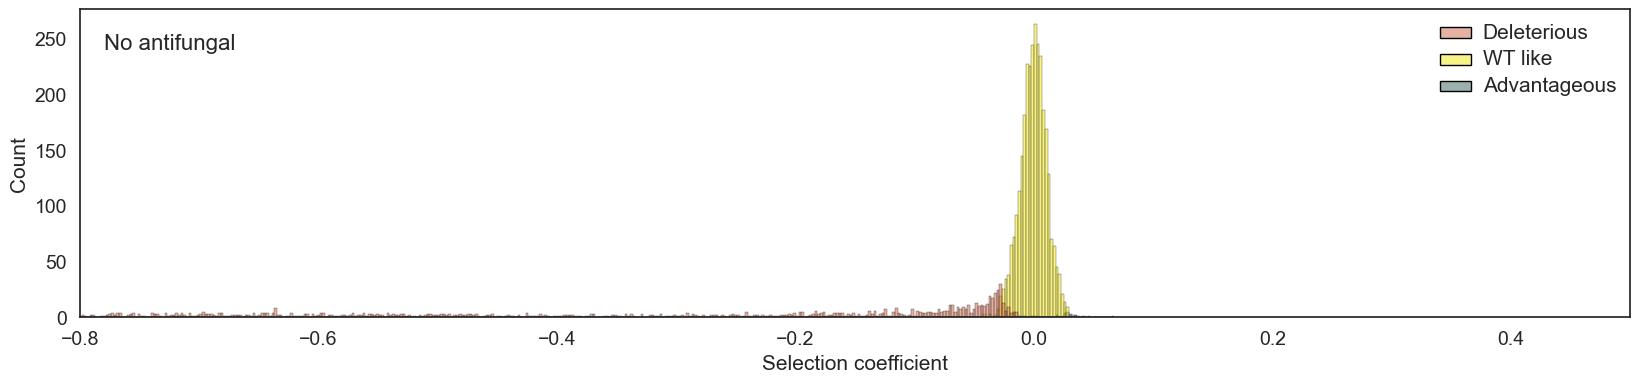

In [77]:
sns.set_style("white")
sns.set_theme(style="white", palette=None)

plt.subplots(figsize=(20, 4))
custom_palette = sns.blend_palette(["#CF6448", "#F6EA0E", "#386461"], n_colors=3)

plot = sns.histplot(data=df_del, x="select_coef", edgecolor="black", hue="result", palette=custom_palette, bins=500)

legend = plot.get_legend()  
legend.set_title("", prop={"size": 16} ) 
legend.set_frame_on(False)
for label in legend.get_texts():  
    label.set_size(15)  
    
plt.xlim(-0.8, 0.5)
#plt.title(condition + " - distribution of the selection coefficient", fontsize=20)

plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)

plt.xlabel('Selection coefficient', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

plt.text(-0.78,240, condition , fontsize = 16)
    
plt.rcParams['svg.fonttype'] = 'none'
name = "Distribution_" + "select_coef_t-test_results_" + condition + "_" +experiment + "_" + date 
plt.savefig(name+ ".png", transparent=True, dpi=750,format='png', bbox_inches='tight')
plt.savefig(name+ ".svg", transparent=True, dpi=750,format='svg', bbox_inches='tight')

In [78]:
#med_anti = med_anti.drop(["level_0","index"], axis=1)
med_anti = med_anti.rename(columns={"aa_variant": "variant"})
name = "Select_coeff_p_value_aa_" + condition + "_" + experiment + "_" + date + ".csv"
med_anti.to_csv(name) 

med_anti

position Antifungal aa  select_coef        p_value  adjusted_p_value  \
0           55       None  *    -0.528211  8.240903e-210     8.053801e-209   
1           55       None  A    -0.004103   7.384538e-01      8.869498e-01   
2           55       None  C    -0.009924   3.218775e-01      5.661675e-01   
3           55       None  D    -0.057636   9.785407e-11      4.824697e-10   
4           55       None  E    -0.014590   3.389770e-02      9.943499e-02   
...        ...        ... ..          ...            ...               ...   
4017       511       None  S    -0.027139   1.626092e-03      6.210924e-03   
4018       511       None  T    -0.021492   4.567569e-03      1.635361e-02   
4019       511       None  V    -0.008682   3.179706e-01      5.618751e-01   
4020       511       None  W    -0.042223   1.157253e-02      3.861880e-02   
4021       511       None  Y    -0.030627   1.256633e-05      5.476859e-05   

     variant  
0        55*  
1        55A  
2        55C  
3        55D  
4        55E  
...      ...  
4017    511S  
4018    511T  
4019    511V  
4020    511W  
4021    511Y  

[4022 rows x 7 columns]